In [1]:
import numpy as np
import pandas as pd
import nibabel as nib

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, time
import itertools

import dipy.tracking.utils
import dipy.tracking.streamline

from scipy.stats import pearsonr, spearmanr
from scipy.special import logit

from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
%run load_connectivity_data.ipynb

File suffix is not defined, using '_after_shift.csv' instead.
File suffix is not defined, using '_after_shift.csv' instead.
File suffix is not defined, using '_after_shift.csv' instead.
File suffix is not defined, using '_after_shift.csv' instead.
File suffix is not defined, using '_after_shift.csv' instead.
File suffix is not defined, using '_after_shift.csv' instead.
File suffix is not defined, using '_after_shift.csv' instead.
File suffix is not defined, using '_after_shift.csv' instead.
File suffix is not defined, using '_after_shift.csv' instead.


In [3]:
def show_firing_electrodes(data_pd, electrode_locations):
    
    fig, ax = plt.subplots(
        electrode_locations.shape[0], electrode_locations.shape[1],
        figsize=(1.75 * electrode_locations.shape[1], 1.75 * electrode_locations.shape[0]),
        sharex=True, sharey=True
    )
    
    delay_matrix = get_evoked_potential_delay_matrix(data_pd)
    distance_matrix = get_streamlines_min_length_matrix(data_pd)
    
    electrodes = sorted(data_pd.iloc[:, 1].unique())

#     for row_id in range(electrode_locations.shape[0]):
#         for col_id in range(electrode_locations.shape[1]):
#             ax[row_id, col_id].set_visible(False)

    for i in range(len(electrodes)):
        electrode_coords = get_electrode_coords(electrode_locations, electrodes[i])
        
        row_id = electrode_coords[0]
        col_id = electrode_coords[1]
        
        distance_vector = distance_matrix[:, i]
        
        electrode_fired_idx = delay_matrix[:, i] > 0
        fired_distance_vector = distance_vector[electrode_fired_idx]
        
        plt.sca(ax[row_id, col_id])

        sns.distplot(
            distance_vector, bins=np.arange(0, 200, 20), 
            label='tractography', norm_hist=False, kde=False
        )
        sns.distplot(
            fired_distance_vector, bins=np.arange(0, 200, 20), 
            label='tractography', norm_hist=False, kde=False
        )
                
        ax[row_id, col_id].set_visible(True)


# Topological maps

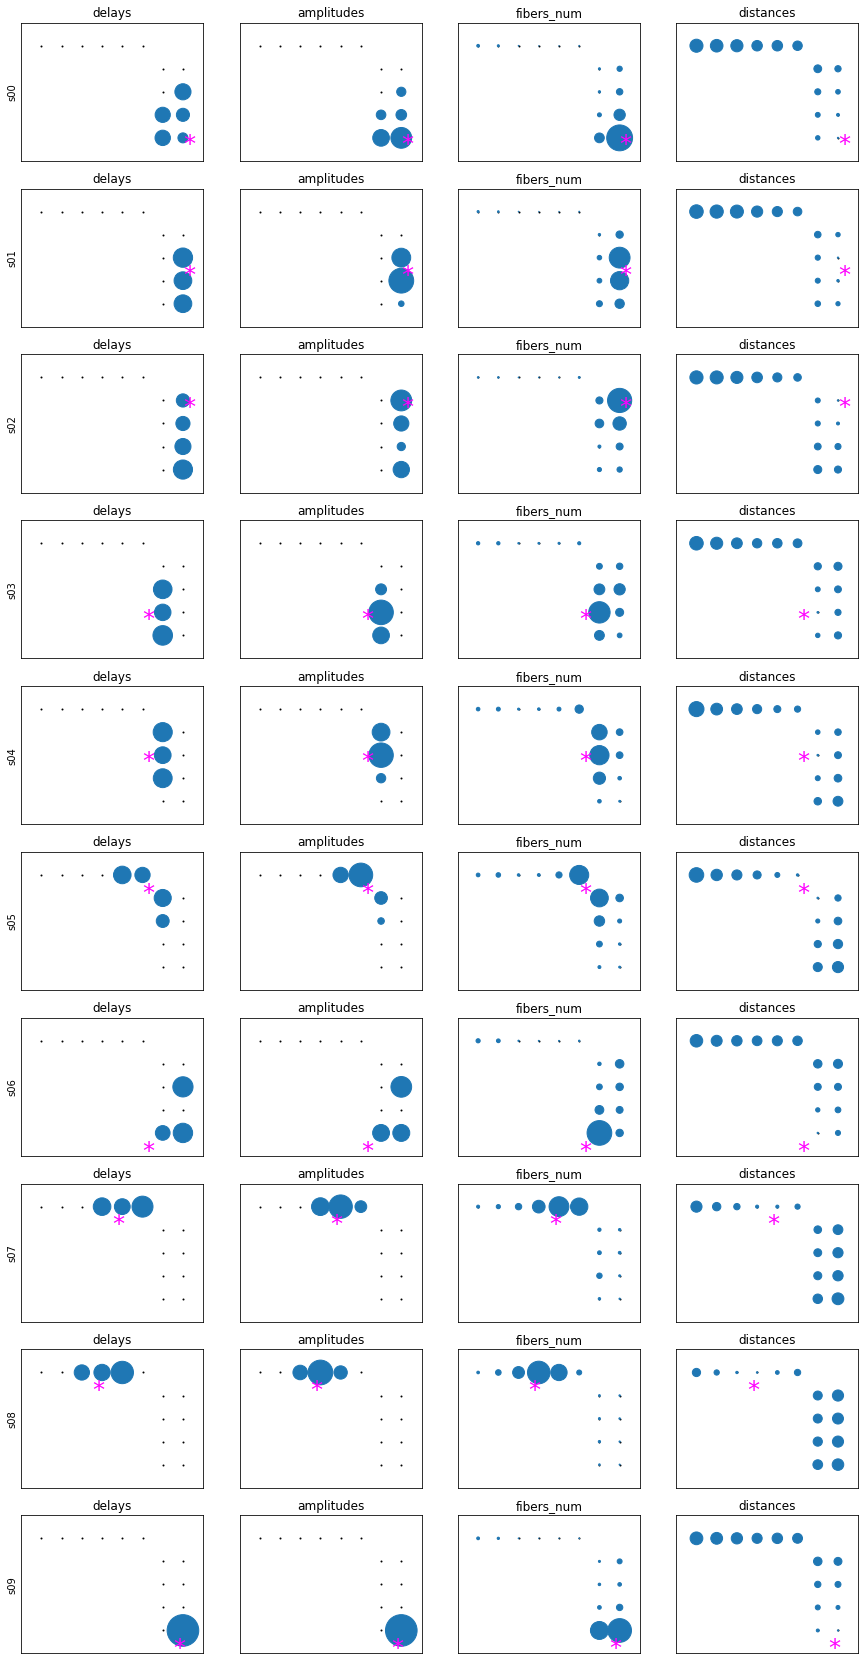

In [4]:
patient_id = 1
show_intensities(data_pd[patient_id], electrode_locations[patient_id], stimulation_site_locations[patient_id])

In [5]:
def show_delay_intensities(data_pd, electrode_locations, stimulation_site_locations, stimulation_sites = None):

    if stimulation_sites == None:
        stimulation_sites = data_pd.iloc[:, 0].unique()
    
    stimulation_sites_num = len(stimulation_sites)

    cols_num = 5
    rows_num = int(np.ceil(stimulation_sites_num / cols_num))
    
    fig, ax = plt.subplots(
        rows_num, cols_num, 
        figsize=(3 * cols_num, 2 * rows_num)
    )

    for i in range(stimulation_sites_num):
        stimulation_site = stimulation_sites[i]

        x = []
        y = []

        s_latencies = []

        for stimulation_record in data_pd[data_pd.iloc[:, 0] == stimulation_site].iterrows():

            electrode_coords = get_electrode_coords(electrode_locations, stimulation_record[1][1])

            x.append(electrode_coords[1])
            y.append(electrode_coords[0])

            if stimulation_record[1][10] > 0:
                s_latencies.append(stimulation_record[1][10])
            else:
                s_latencies.append(0)

        stim_coords = get_stimulation_site_coords(
            electrode_locations, stimulation_site_locations, stimulation_site
        )
    
        row_id = int(np.floor(i / cols_num))
        col_id = np.mod(i, cols_num)
    
        s_norm = s_latencies / np.sum(np.array(s_latencies))

        ax[row_id, col_id].scatter(x, y, s=8, color='black', marker='s')
        ax[row_id, col_id].scatter(x, y, s=600*s_norm, color='red')
        ax[row_id, col_id].text(stim_coords[0], stim_coords[1], '✖', fontsize=20, color='limegreen')

        plt.sca(ax[row_id, col_id])
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-1.25, electrode_locations.shape[1] + 0.25])
        plt.ylim([-1.25, electrode_locations.shape[0] + 0.25])

#         if j == 0:
#             plt.ylabel(stimulation_site)

        plt.gca().invert_yaxis()
       
    plt.savefig("patient%02d_topology_delays.pdf" % patient_labels[patient_id], bbox_inches = 'tight')
    plt.savefig("patient%02d_topology_delays.eps" % patient_labels[patient_id], bbox_inches = 'tight')


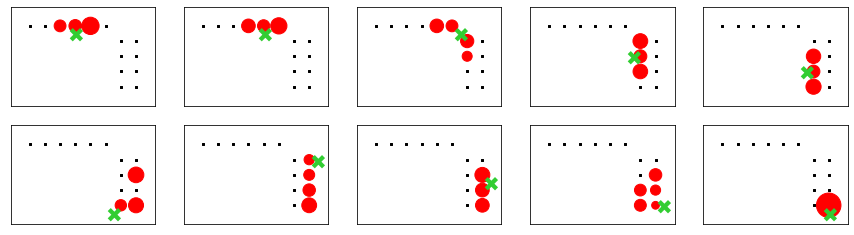

In [6]:
patient_id = 1
show_delay_intensities(
    data_pd[patient_id], electrode_locations[patient_id], stimulation_site_locations[patient_id],
    ['s08', 's07', 's05', 's04', 's03', 's06', 's02', 's01', 's00', 's09']
)

# Firing electrodes
What connection probability is needed for an electrode to "fire"?

In [7]:
def get_tp_matrix(test, ref):
    return np.logical_and(test, ref)

def get_tn_matrix(test, ref):
    return np.logical_not(np.logical_or(test, ref))

def get_fp_matrix(test, ref):
    return np.logical_and(test, np.logical_not(ref))
    
def get_fn_matrix(test, ref):
    return np.logical_and(np.logical_not(test), ref)

def get_tp(test, ref):
    return np.sum(get_tp_matrix(test, ref))

def get_tn(test, ref):
    return np.sum(get_tn_matrix(test, ref))
    
def get_fp(test, ref):
    return np.sum(get_fp_matrix(test, ref))

def get_fn(test, ref):
    return np.sum(get_fn_matrix(test, ref))

def get_sensitivity(test, ref):
    return get_tp(test, ref) / (get_tp(test, ref) + get_fn(test, ref))

def get_specificity(test, ref):
    return get_tn(test, ref) / (get_tn(test, ref) + get_fp(test, ref))

def get_jaccard_index(test, ref):
    return get_tp(test, ref) / (get_tp(test, ref) + get_fp(test, ref) + get_fn(test, ref))

def get_accuracy(test, ref):
    return (get_tp(test, ref) + get_tn(test, ref)) / (test.shape[0] * test.shape[1])

def get_f1_score(test, ref):
    return 2 * get_tp(test, ref) / (2 * get_tp(test, ref) + get_fp(test, ref) + get_fn(test, ref)) 


def find_optimal_threshold(structural_connectivity_matrix, functional_connectivity_matrix, eval_fun):
    
    peak_value = -np.infty
    peak_threshold = 0
    
    for cur_threshold in np.sort(np.unique(np.ravel(structural_connectivity_matrix))):

        cur_value = eval_fun(
            structural_connectivity_matrix >= cur_threshold, 
            functional_connectivity_matrix > 0
        )
        
        if cur_value > peak_value:
            peak_value = cur_value
            peak_threshold = cur_threshold
            
    return peak_threshold



In [8]:
def show_binarized_connectivity(
    structural_connectivity_matrix, functional_connectivity_matrix, connectivity_threshold, patient_id, axs
):
  
    binarized_structural_connectivity_matrix = np.zeros_like(structural_connectivity_matrix)
    binarized_functional_connectivity_matrix = np.zeros_like(functional_connectivity_matrix)

    binarized_structural_connectivity_matrix[structural_connectivity_matrix >= connectivity_threshold] = 1
    binarized_functional_connectivity_matrix[functional_connectivity_matrix > 0] = 1
    
    plt.sca(axs[0])
    sns.heatmap(binarized_structural_connectivity_matrix, vmin=0, vmax=1)
    plt.ylabel("Patient #%d\n\nstimulation sites" % patient_id)
    plt.xlabel("recording electrodes")
    if i == 0:
        plt.title("streamlines based connectivity")

    plt.sca(axs[1])
    sns.heatmap(binarized_functional_connectivity_matrix, vmin=0, vmax=1)
    plt.xlabel("recording electrodes")
    plt.ylabel("stimulation sites")
    if i == 0:
        plt.title("P1's based connectivity")
        
    plt.sca(axs[2])
    plt.hist(np.ravel(structural_connectivity_matrix), np.arange(0.001, 0.101, 0.002))
    plt.plot([connectivity_threshold, connectivity_threshold], [0, 30])
    plt.xlabel("connectivity")

    streamlines_length_matrix = get_streamlines_min_length_matrix(data_pd[patient_id])
    
    functiontal_based_streamlines_lengths = np.ravel(
        streamlines_length_matrix[functional_connectivity_matrix > 0]
    )
    thresholded_structural_based_streamlines_lengths = np.ravel(
        streamlines_length_matrix[structural_connectivity_matrix >= connectivity_threshold]
    )

    plt.sca(axs[3])    
    sns.distplot(
        np.ravel(streamlines_length_matrix), bins=np.arange(0, 300, 20), 
        label='tractography', norm_hist=False, kde=False
    )
    sns.distplot(
        thresholded_structural_based_streamlines_lengths, bins=np.arange(0, 300, 20), 
        label='thresholded tractography', norm_hist=False, kde=False
    )
    sns.distplot(
        functiontal_based_streamlines_lengths, bins=np.arange(0, 300, 20), 
        label='electrical stimulation', norm_hist=False, kde=False
    )
    
    pairs_num = np.prod(binarized_structural_connectivity_matrix.shape)
    
    tp_num = get_tp(binarized_structural_connectivity_matrix, binarized_functional_connectivity_matrix)
    fp_num = get_fp(binarized_structural_connectivity_matrix, binarized_functional_connectivity_matrix)
    tn_num = get_tn(binarized_structural_connectivity_matrix, binarized_functional_connectivity_matrix)
    fn_num = get_fn(binarized_structural_connectivity_matrix, binarized_functional_connectivity_matrix)
    
    tp_percent = round(100 * tp_num / pairs_num)
    fp_percent = round(100 * fp_num / pairs_num)
    tn_percent = round(100 * tn_num / pairs_num)
    fn_percent = 100 - tp_percent - fp_percent - tn_percent
    
    result = [
        connectivity_threshold, 
        np.max(thresholded_structural_based_streamlines_lengths),
        get_jaccard_index(binarized_structural_connectivity_matrix, binarized_functional_connectivity_matrix),
        get_sensitivity(binarized_structural_connectivity_matrix, binarized_functional_connectivity_matrix), 
        get_specificity(binarized_structural_connectivity_matrix, binarized_functional_connectivity_matrix),
        get_f1_score(binarized_structural_connectivity_matrix, binarized_functional_connectivity_matrix),
        tp_percent, fp_percent, tn_percent, fn_percent
    ]
    
    print("#%d\t%.3f\t%dmm\t%.2f\t%.2f\t%.2f\t%.2f\t%d (%d%%)\t%d (%d%%)\t%d (%d%%)\t%d (%d%%)" % (
        patient_id, 
        result[0], result[1], result[2], result[3], result[4], result[5],
        tp_num, result[6],
        fp_num, result[7],
        tn_num, result[8],
        fn_num, result[9]
    ))

    plt.legend()
    plt.xlabel("streamline lengths")
    
    return result


# Streamlines count based binarization

patient	thresh	max_l	JI	sensit	specif	f1	tp	fp	tn	fn
#1	0.008	25mm	0.68	0.81	0.94	0.81	26 (19%)	6 (4%)	102 (73%)	6 (4%)
#3	0.014	17mm	0.46	0.67	0.96	0.63	6 (6%)	4 (4%)	87 (87%)	3 (3%)
#4	0.006	33mm	0.52	0.85	0.91	0.69	22 (11%)	16 (8%)	154 (79%)	4 (2%)
#6	0.009	36mm	0.67	0.74	0.97	0.80	20 (16%)	3 (2%)	96 (76%)	7 (6%)
#7	0.007	35mm	0.54	0.76	0.90	0.70	22 (14%)	12 (8%)	113 (73%)	7 (5%)
#8	0.017	19mm	0.43	0.86	0.88	0.60	6 (9%)	7 (11%)	50 (78%)	1 (2%)
#10	0.008	26mm	0.57	0.67	0.94	0.73	24 (17%)	6 (4%)	98 (70%)	12 (9%)
#11	0.008	55mm	0.61	0.84	0.89	0.76	31 (18%)	14 (8%)	117 (70%)	6 (4%)
#12	0.007	30mm	0.66	0.89	0.88	0.80	39 (23%)	15 (9%)	109 (65%)	5 (3%)
avg: 0.009	31mm	0.57	0.79	0.92	0.72	15	6	75	4
std: 0.004	11mm	0.09	0.08	0.03	0.07	5	3	6	2


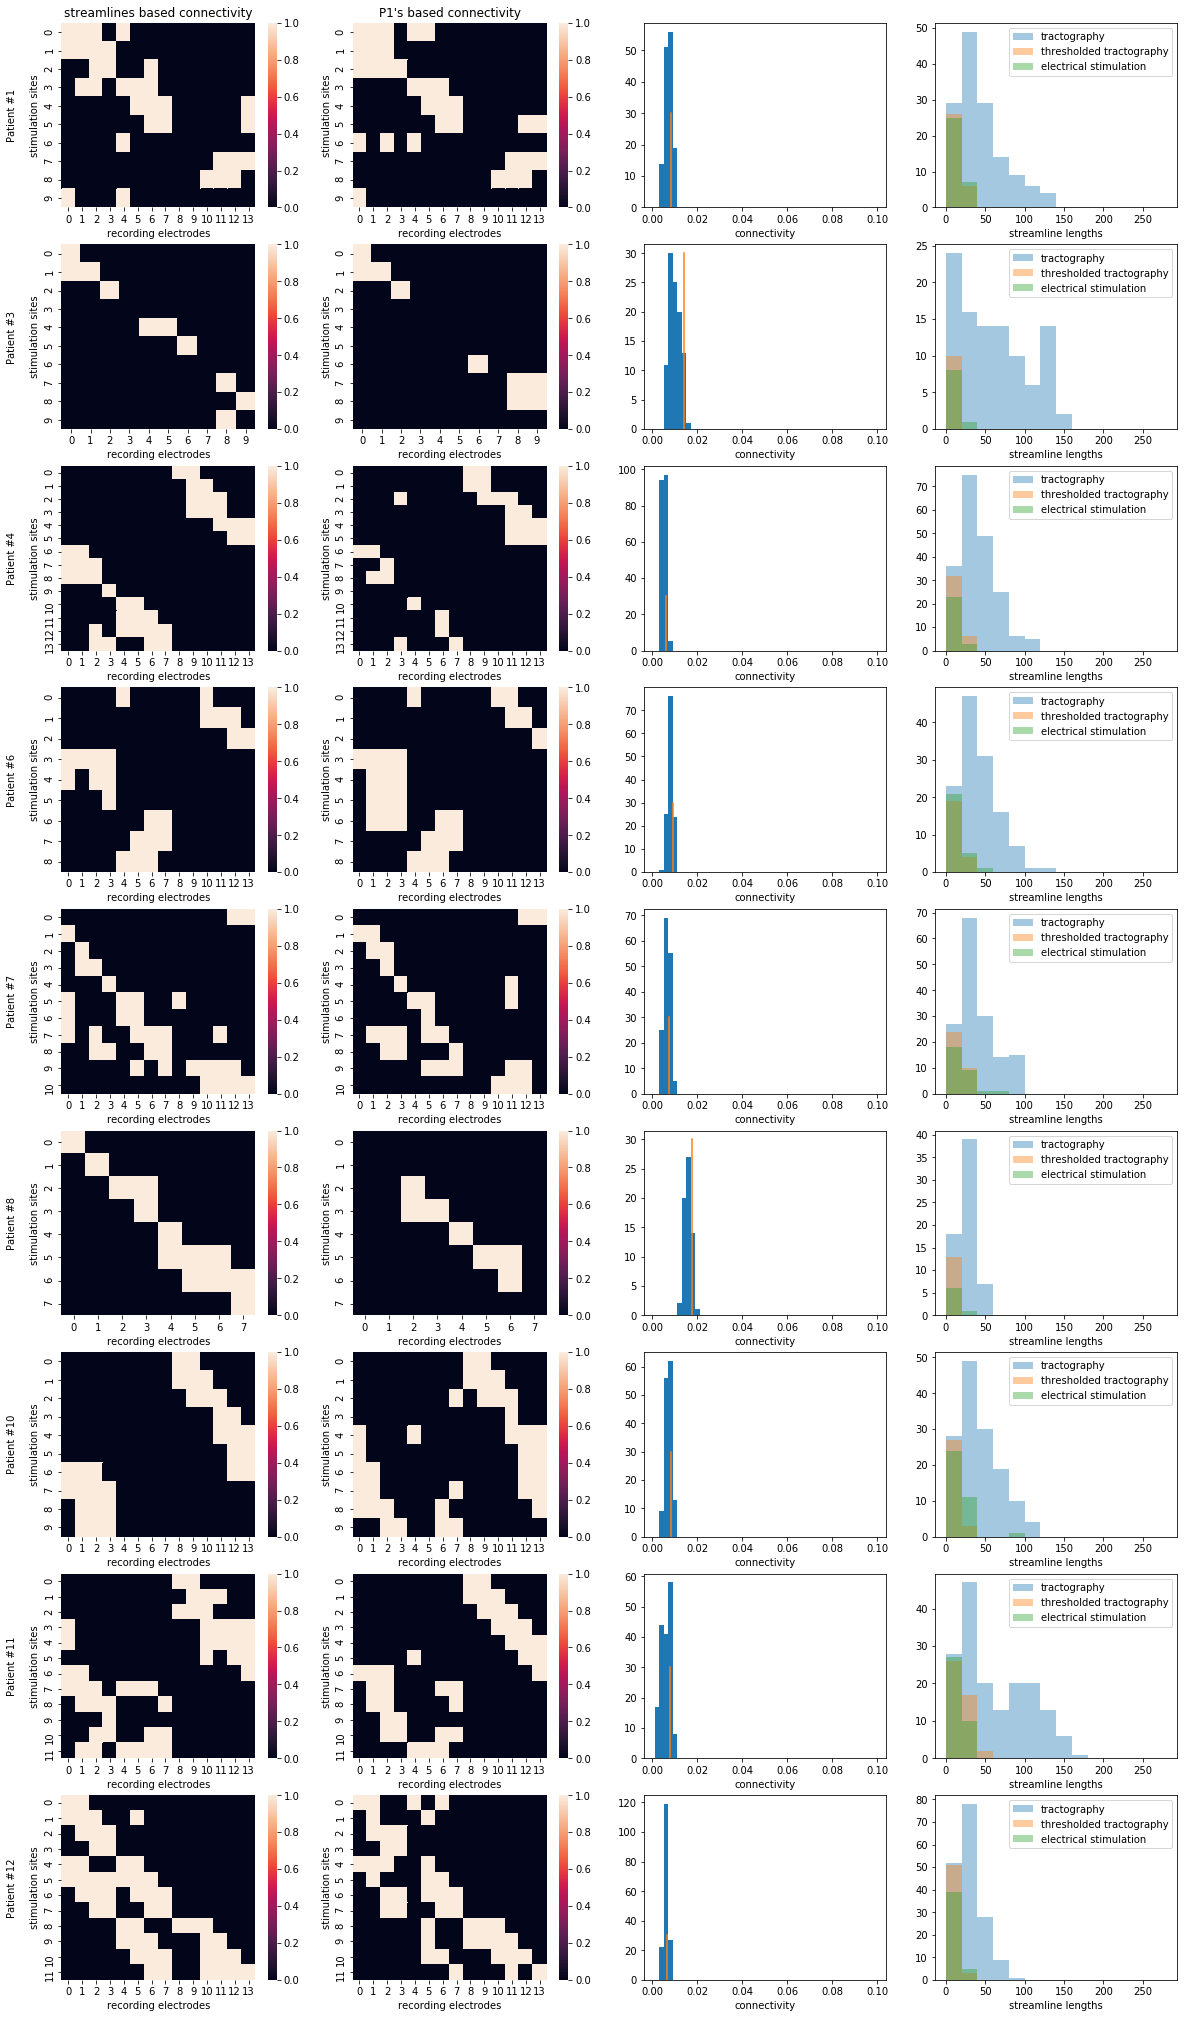

In [9]:
fibers_num_thresholds = {}

patient_ids = sorted(data_pd.keys())
patients_num = len(patient_ids)

_, ax = plt.subplots(patients_num, 4, figsize=(20, 4 * patients_num))

print("patient\tthresh\tmax_l\tJI\tsensit\tspecif\tf1\ttp\tfp\ttn\tfn")

summary = []
for i in range(patients_num):

    patient_id = patient_ids[i]
    
    structural_connectivity_matrix = get_log_count_based_connectivity_matrix(data_pd[patient_id])
    functional_connectivity_matrix = get_amplitude_based_connectivity_matrix(data_pd[patient_id])
    
    fibers_num_thresholds[patient_id] = find_optimal_threshold(
        structural_connectivity_matrix, functional_connectivity_matrix, get_jaccard_index
    )

    summary.append(
        show_binarized_connectivity(
            structural_connectivity_matrix, functional_connectivity_matrix,
            fibers_num_thresholds[patient_id], patient_id, ax[i]
        )
    )
    
plt.savefig("binarization.pdf")

summary_avg = np.average(np.array(summary), axis=0)
summary_std = np.std(np.array(summary), axis=0)

print("avg: %.3f\t%dmm\t%.2f\t%.2f\t%.2f\t%.2f\t%d\t%d\t%d\t%d" % (
    np.round(summary_avg[0], 3), np.round(summary_avg[1]), 
    np.round(summary_avg[2], 2), np.round(summary_avg[3], 2), np.round(summary_avg[4], 2), np.round(summary_avg[5], 2), 
    np.round(summary_avg[6]), np.round(summary_avg[7]), np.round(summary_avg[8]), np.round(summary_avg[9])
))
print("std: %.3f\t%dmm\t%.2f\t%.2f\t%.2f\t%.2f\t%d\t%d\t%d\t%d" % (
    np.round(summary_std[0], 3), np.round(summary_std[1]), 
    np.round(summary_std[2], 2), np.round(summary_std[3], 2), np.round(summary_std[4], 2), np.round(summary_std[5], 2), 
    np.round(summary_std[6]), np.round(summary_std[7]), np.round(summary_std[8]), np.round(summary_std[9])
))


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

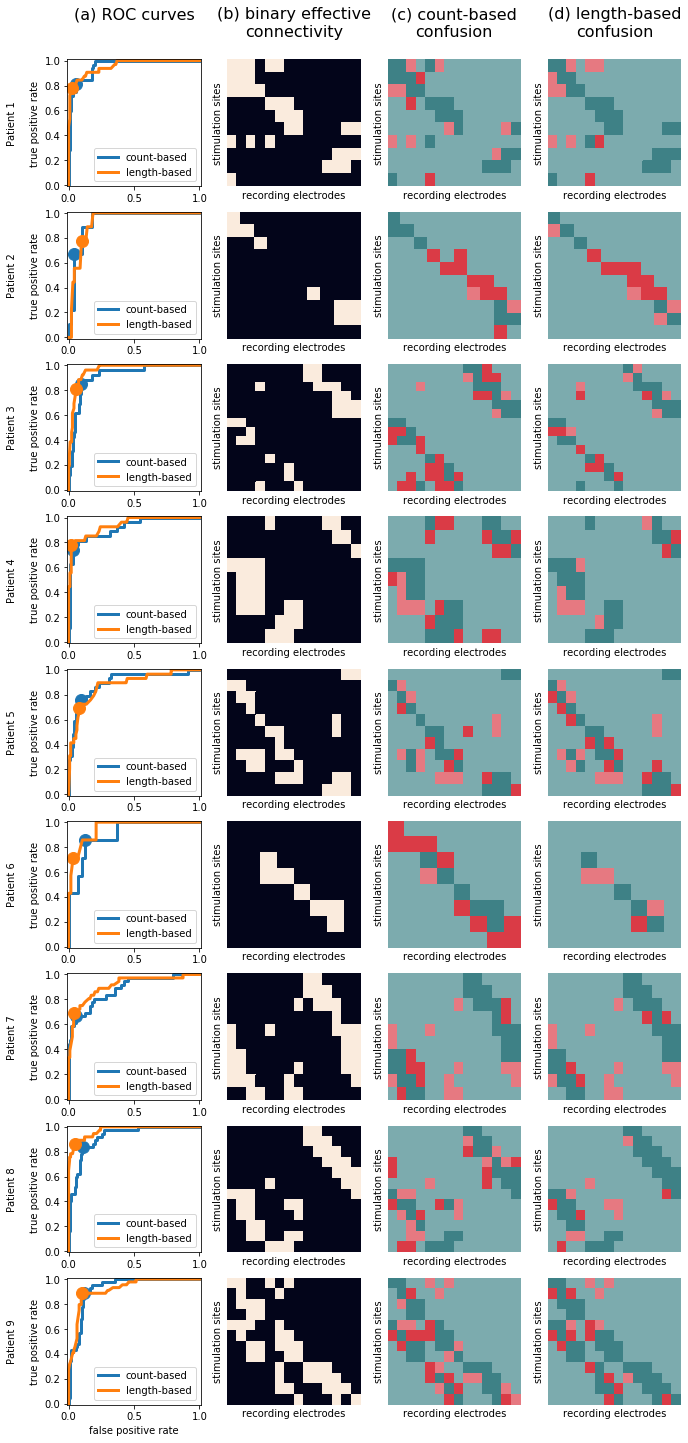

In [10]:
def get_roc_curve(structural_connectivity_matrix, functional_connectivity_matrix):
    
    thresholds = np.sort(np.unique(np.ravel(structural_connectivity_matrix)))
    scores = np.zeros([3, len(thresholds) + 2])
    
    functional_bin = functional_connectivity_matrix > 0

    for i in range(len(thresholds)):

        structural_bin = structural_connectivity_matrix >= thresholds[i]
        
        scores[:, i + 1] = [        
            1 - get_specificity(structural_bin, functional_bin),
            get_sensitivity(structural_bin, functional_bin),
            get_jaccard_index(structural_bin, functional_bin)
        ]
    
    scores[0, 0] = 1
    scores[1, 0] = 1
    
    return scores, thresholds


def get_classification_matrix(test, ref):
    
    return 1 * get_tp_matrix(test, ref) - 1 * get_fp_matrix(test, ref) + 0.75 * get_tn_matrix(test, ref) - 0.75 * get_fn_matrix(test, ref)


patient_ids = sorted(data_pd.keys())
patients_num = len(patient_ids)

_, axs = plt.subplots(patients_num, 4, figsize=(2.75 * 4, 2.75 * patients_num))

for i in range(patients_num):

    patient_id = patient_ids[i]
    effective_connectivity_bin = get_amplitude_based_connectivity_matrix(data_pd[patient_id]) > 0

    # --- effective connectivity ---
    
    plt.sca(axs[i, 1])
    sns.heatmap(effective_connectivity_bin, vmin=0, vmax=1, cbar=False)
    plt.xlabel("recording electrodes")
    plt.ylabel("stimulation sites")
    plt.xticks([])
    plt.yticks([])
    
    if i == 0:    
        plt.title("(b) binary effective\nconnectivity\n", fontsize=16)

    # --- count-based connectivity ---
    
    scores, thresholds = get_roc_curve(    
#         get_count_based_connectivity_matrix(data_pd[patient_id]),
        get_log_count_based_connectivity_matrix(data_pd[patient_id]),
        get_amplitude_based_connectivity_matrix(data_pd[patient_id])
    )
  
    arg_max_jaccard_index = np.argmax(scores[2])
    structural_connectivity_bin = get_count_based_connectivity_matrix(data_pd[patient_id]) >= thresholds[arg_max_jaccard_index]

    plt.sca(axs[i, 0])
    plt.plot(scores[0], scores[1], linewidth=3, label="count-based", color="C0")
    plt.plot(scores[0, arg_max_jaccard_index], scores[1, arg_max_jaccard_index], marker="o", markersize=12, color="C0")

    plt.sca(axs[i, 2])
    sns.heatmap(
        get_classification_matrix(structural_connectivity_bin, effective_connectivity_bin), 
        vmin=-1, vmax=1, cmap=sns.diverging_palette(10, 200, sep=80, n=100), cbar=False
    )
    plt.xlabel("recording electrodes")
    plt.ylabel("stimulation sites")
    plt.xticks([])
    plt.yticks([])
    
    if i == 0:
        plt.title("(c) count-based\nconfusion\n", fontsize=16)
    
    # --- length-based connectivity ---
        
    scores, thresholds = get_roc_curve(    
        get_inversed_streamlines_min_length_based_connectivity_matrix(data_pd[patient_id]),
        get_amplitude_based_connectivity_matrix(data_pd[patient_id])
    )
    
    arg_max_jaccard_index = np.argmax(scores[2])
    structural_connectivity_bin = get_inversed_streamlines_min_length_based_connectivity_matrix(data_pd[patient_id]) >= thresholds[arg_max_jaccard_index]
    
    plt.sca(axs[i, 0])
    plt.plot(scores[0], scores[1], linewidth=3, label="length-based", color="C1")
    plt.plot(scores[0, arg_max_jaccard_index], scores[1, arg_max_jaccard_index], marker="o", markersize=12, color="C1")

    plt.sca(axs[i, 3])
    sns.heatmap(
        get_classification_matrix(structural_connectivity_bin, effective_connectivity_bin), 
        vmin=-1, vmax=1, cmap=sns.diverging_palette(10, 200, sep=80, n=100), cbar=False
    )
    plt.xlabel("recording electrodes")
    plt.ylabel("stimulation sites")
    plt.xticks([])
    plt.yticks([])
    
    if i == 0:
        plt.title("(d) length-based\nconfusion\n", fontsize=16)
    
    plt.sca(axs[i, 0])
    
    if i == patients_num - 1:
        plt.xlabel("false positive rate")
    plt.ylabel("Patient %d\n\ntrue positive rate" % patient_labels[patient_id])
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    
    plt.legend(loc = "lower right")
    
    if i == 0:
        plt.title("(a) ROC curves\n\n", fontsize=16)
    
plt.savefig("binary_connectivity_comparison.pdf", bbox_inches = 'tight')
plt.savefig("binary_connectivity_comparison.eps", bbox_inches = 'tight')
   


# Streamlines length based binarization

patient	thresh	max_l	JI	sensit	specif	f1
#1	0.010	18mm	0.71	0.78	0.97	0.83	25 (18%)	3 (2%)	105 (75%)	7 (5%)
#3	0.020	17mm	0.39	0.78	0.90	0.56	7 (7%)	9 (9%)	82 (82%)	2 (2%)
#4	0.008	17mm	0.60	0.81	0.95	0.75	21 (11%)	9 (5%)	161 (82%)	5 (2%)
#6	0.012	19mm	0.72	0.78	0.98	0.84	21 (17%)	2 (2%)	97 (77%)	6 (4%)
#7	0.009	20mm	0.51	0.69	0.92	0.68	20 (13%)	10 (6%)	115 (75%)	9 (6%)
#8	0.024	14mm	0.56	0.71	0.96	0.71	5 (8%)	2 (3%)	55 (86%)	2 (3%)
#10	0.009	21mm	0.62	0.69	0.96	0.77	25 (18%)	4 (3%)	100 (71%)	11 (8%)
#11	0.009	24mm	0.74	0.86	0.95	0.85	32 (19%)	6 (4%)	125 (74%)	5 (3%)
#12	0.007	19mm	0.68	0.89	0.90	0.81	39 (23%)	13 (8%)	111 (66%)	5 (3%)
avg: 0.012	20mm	0.62	0.78	0.94	0.76	15	5	76	4
std: 0.006	3mm	0.11	0.07	0.03	0.09	5	2	6	2


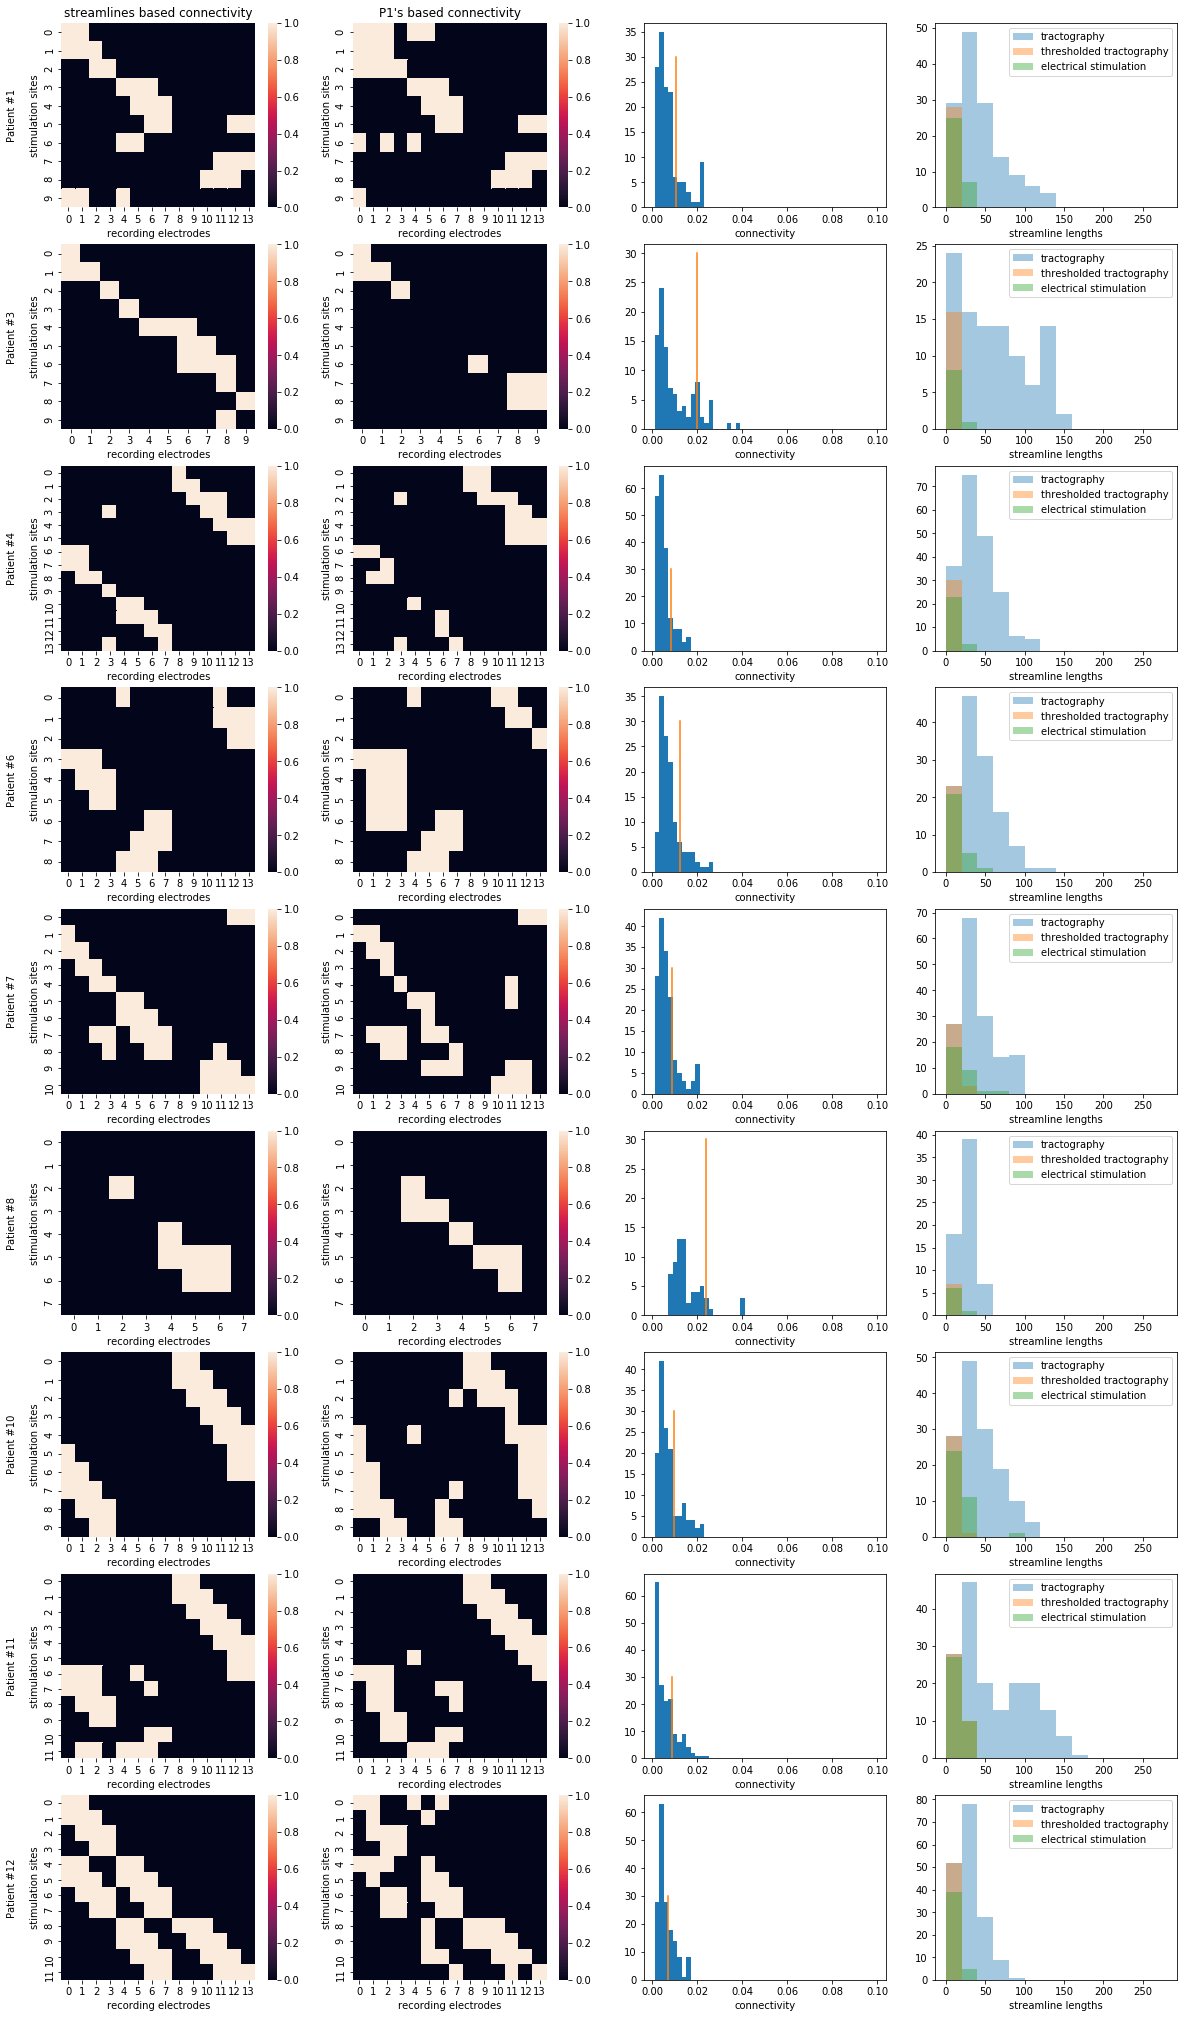

In [11]:
distance_thresholds = {}

patient_ids = sorted(data_pd.keys())
patients_num = len(patient_ids)

_, ax = plt.subplots(patients_num, 4, figsize=(20, 4 * patients_num))

print("patient\tthresh\tmax_l\tJI\tsensit\tspecif\tf1")

summary = []
for i in range(patients_num):

    patient_id = patient_ids[i]
    
    structural_connectivity_matrix = get_inversed_streamlines_min_length_based_connectivity_matrix(data_pd[patient_id])
    functional_connectivity_matrix = get_amplitude_based_connectivity_matrix(data_pd[patient_id])
    
    distance_thresholds[patient_id] = find_optimal_threshold(
        structural_connectivity_matrix, functional_connectivity_matrix, get_jaccard_index
    )

    summary.append(
        show_binarized_connectivity(
            structural_connectivity_matrix, functional_connectivity_matrix,
            distance_thresholds[patient_id], patient_id, ax[i]
        )
    )
    
summary_avg = np.average(np.array(summary), axis=0)
summary_std = np.std(np.array(summary), axis=0)

print("avg: %.3f\t%dmm\t%.2f\t%.2f\t%.2f\t%.2f\t%d\t%d\t%d\t%d" % (
    np.round(summary_avg[0], 3), np.round(summary_avg[1]), 
    np.round(summary_avg[2], 2), np.round(summary_avg[3], 2), np.round(summary_avg[4], 2), np.round(summary_avg[5], 2), 
    np.round(summary_avg[6]), np.round(summary_avg[7]), np.round(summary_avg[8]), np.round(summary_avg[9])
))
print("std: %.3f\t%dmm\t%.2f\t%.2f\t%.2f\t%.2f\t%d\t%d\t%d\t%d" % (
    np.round(summary_std[0], 3), np.round(summary_std[1]), 
    np.round(summary_std[2], 2), np.round(summary_std[3], 2), np.round(summary_std[4], 2), np.round(summary_std[5], 2), 
    np.round(summary_std[6]), np.round(summary_std[7]), np.round(summary_std[8]), np.round(summary_std[9])
))
    

# Data filtering

In [12]:
masks = {}

for patient_id in sorted(data_pd.keys()):
    masks[patient_id] = get_evoked_potential_delay_matrix(data_pd[patient_id]) > 0
#     masks[patient_id] = 1|
#     masks[patient_id] = get_count_based_connectivity_matrix(data_pd[patient_id]) >= fibers_num_thresholds[patient_id]
#     masks[patient_id] = get_inversed_streamlines_min_length_based_connectivity_matrix(data_pd[patient_id]) >= distance_thresholds[patient_id]


# Scatter plots

In [13]:
def show_scatterplots_item(data_pd, variable_pairs, mask, fig, ax, patient_id):

    scatterplot_data = {}
    
    scatterplot_data['delays'] = {
        'samples' : np.ravel(get_evoked_potential_delay_matrix(data_pd)),
        'range'   : [15, 70], # [0, 100],
        'label'   : "P1\'s delays [ms]"
    }
    
    scatterplot_data['amplitudes'] = {
        'samples' : np.ravel(get_evoked_potential_amplitude_matrix(data_pd)),
        'range'   : [0.00001, 0.001],
        'label'   : "P1\'s amplitudes [V]"
    }
    
    scatterplot_data['sqrt_amplitudes'] = {
        'samples' : np.sqrt(np.ravel(get_evoked_potential_amplitude_matrix(data_pd))),
        'range'   : np.sqrt(np.array([0.00001, 0.001])),
        'label'   : "sqrt of P1\'s amplitudes [V]"
    }
    
    scatterplot_data['log_min_streamlines_lengths'] = {
        'samples' : np.ravel(get_streamlines_log_min_length_matrix(data_pd)),
        'range'   : [0.5, 2.5], 
        'label'   : "streamlines log min lengths [mm]"
    }
    
    scatterplot_data['min_streamlines_lengths'] = {
        'samples' : np.ravel(get_streamlines_min_length_matrix(data_pd)),
        'range'   : [0, 120], # [0, 120],
        'label'   : "streamlines min lengths [mm]"
    }
    
    scatterplot_data['minus_min_streamlines_lengths'] = {
        'samples' : 1.0 / (1 + np.ravel(get_streamlines_min_length_matrix(data_pd))),
        'range'   : [-120, 0], 
        'label'   : "minus streamlines min lengths [mm]"
    }
    
    scatterplot_data['sqrt_min_streamlines_lengths'] = {
        'samples' : np.ravel(get_streamlines_sqrt_min_length_matrix(data_pd)),
        'range'   : [0, 10], # [0, 120],
        'label'   : "streamlines squared min lengths [mm^2]"
    }
    
    scatterplot_data['max_streamlines_lengths'] = {
        'samples' : np.ravel(get_streamlines_max_length_matrix(data_pd)),
        'range'   : [0, 300], # [0, 120],
        'label'   : "streamlines min lengths [mm]"
    }
    
    scatterplot_data['avg_streamlines_lengths'] = {
        'samples' : np.ravel(get_streamlines_avg_length_matrix(data_pd)),
        'range'   : [0, 200], # [0, 120],
        'label'   : "streamlines avg lengths [mm]"
    }
    
    scatterplot_data['median_streamlines_lengths'] = {
        'samples' : np.ravel(get_streamlines_median_length_matrix(data_pd)),
        'range'   : [0, 200], # [0, 120],
        'label'   : "streamlines median lengths [mm]"
    }
    
    scatterplot_data['min_streamlines_lengths_trk'] = {
        'samples' : np.ravel(get_trk_streamlines_min_length_matrix(data_pd)),
        'range'   : [0, 120], # [0, 120],
        'label'   : "streamlines min lengths [mm]"
    }
    
    scatterplot_data['max_streamlines_lengths_trk'] = {
        'samples' : np.ravel(get_trk_streamlines_max_length_matrix(data_pd)),
        'range'   : [0, 300], # [0, 120],
        'label'   : "streamlines min lengths [mm]"
    }
    
    scatterplot_data['median_streamlines_lengths_trk'] = {
        'samples' : np.ravel(get_trk_streamlines_median_length_matrix(data_pd)),
        'range'   : [0, 200], # [0, 120],
        'label'   : "streamlines median lengths [mm]"
    }
    
    scatterplot_data['p10_streamlines_lengths_trk'] = {
        'samples' : np.ravel(get_trk_streamlines_10_length_matrix(data_pd)),
        'range'   : [0, 200], # [0, 120],
        'label'   : "streamlines 10%% lengths [mm]"
    }
    
    scatterplot_data['p20_streamlines_lengths_trk'] = {
        'samples' : np.ravel(get_trk_streamlines_20_length_matrix(data_pd)),
        'range'   : [0, 200], # [0, 120],
        'label'   : "streamlines 20%% lengths [mm]"
    }
    
    scatterplot_data['p30_streamlines_lengths_trk'] = {
        'samples' : np.ravel(get_trk_streamlines_30_length_matrix(data_pd)),
        'range'   : [0, 200], # [0, 120],
        'label'   : "streamlines 30%% lengths [mm]"
    }
    
    scatterplot_data['p40_streamlines_lengths_trk'] = {
        'samples' : np.ravel(get_trk_streamlines_40_length_matrix(data_pd)),
        'range'   : [0, 200], # [0, 120],
        'label'   : "streamlines 40%% lengths [mm]"
    }
    
    scatterplot_data['smoothwm_surface_distances'] = {
        'samples' : np.ravel(get_smoothwm_surface_distance_matrix(data_pd)),
        'range'   : [0, 120],
        'label'   : "smooth-wm surface distances [mm]"
    }

    scatterplot_data['pial_surface_distances'] = {
        'samples' : np.ravel(get_pial_surface_distance_matrix(data_pd)),
        'range'   : [0, 120],
        'label'   : "pial surface distances [mm]"
    }

    scatterplot_data['min_streamlines_lengths_inversed'] = {
        'samples' : np.ravel(get_inversed_streamlines_min_length_matrix(data_pd)),
        'range'   : [0, 0.1], # [0, 0.2],
        'label'   : "1 / streamlines min lengths [1/mm]"
    }
    
    scatterplot_data['max_streamlines_lengths_inversed'] = {
        'samples' : np.ravel(get_inversed_streamlines_max_length_matrix(data_pd)),
        'range'   : [0, 0.1], # [0, 0.2],
        'label'   : "1 / streamlines max lengths [1/mm]"
    }

    scatterplot_data['avg_streamlines_lengths_inversed'] = {
        'samples' : np.ravel(get_inversed_streamlines_avg_length_matrix(data_pd)),
        'range'   : [0, 0.1], # [0, 0.2],
        'label'   : "1 / streamlines avg lengths [1/mm]"
    }

    scatterplot_data['median_streamlines_lengths_inversed'] = {
        'samples' : np.ravel(get_inversed_streamlines_median_length_matrix(data_pd)),
        'range'   : [0, 0.1], # [0, 0.2],
        'label'   : "1 / streamlines median lengths [1/mm]"
    }

    scatterplot_data['smoothwm_surface_distances_inversed'] = {
        'samples' : np.ravel(get_inversed_smoothwm_surface_distance_matrix(data_pd)),
        'range'   : [0, 0.2],
        'label'   : "1 / smooth-wm surface distances [1/mm]"
    }

    scatterplot_data['pial_surface_distances_inversed'] = {
        'samples' : np.ravel(get_inversed_pial_surface_distance_matrix(data_pd)),
        'range'   : [0, 0.2],
        'label'   : "1 / pial surface distances [1/mm]"
    }

    scatterplot_data['fibers_num'] = {
        'samples' : np.ravel(get_streamlines_count_matrix(data_pd)),
        'range'   : [0, 50000],
        'label'   : "streamline counts"
    }
    
    scatterplot_data['fibers_num_inversed'] = {
        'samples' : np.ravel(get_inversed_streamlines_count_matrix(data_pd)),
        'range'   : [0, 1],
        'label'   : "1 / streamline counts"
    }
    
    scatterplot_data['fibers_log_num'] = {
        'samples' : np.ravel(get_streamlines_log_count_matrix(data_pd)),
        'range'   : [0, 50000],
        'label'   : "streamline log counts"
    }
    
    scatterplot_data['fa_average'] = {
        'samples' : np.ravel(get_mean_fa_matrix(data_pd)),
        'range'   : [0, 0.5],
        'label'   : "average FA"
    }
    
    scatterplot_data['md_average'] = {
        'samples' : np.ravel(get_mean_md_matrix(data_pd)),
        'range'   : [0, 0.001],
        'label'   : "average MD"
    }
    
    scatterplot_data['ad_average'] = {
        'samples' : np.ravel(get_mean_ad_matrix(data_pd)),
        'range'   : [0, 0.001],
        'label'   : "average AD"
    }
    
    scatterplot_data['rd_average'] = {
        'samples' : np.ravel(get_mean_rd_matrix(data_pd)),
        'range'   : [0, 0.001],
        'label'   : "average RD"
    }
    
    scatterplot_data['rtop_average'] = {
        'samples' : np.ravel(get_mean_rtop_matrix(data_pd)),
        'range'   : [0, np.power(5000000, 1.0/3)],
        'label'   : "average RTOP"
    }
    
    scatterplot_data['rtap_average'] = {
        'samples' : np.ravel(get_mean_rtap_matrix(data_pd)),
        'range'   : [0, np.power(20000, 1.0/2)],
        'label'   : "average RTAP"
    }
    
    scatterplot_data['rtpp_average'] = {
        'samples' : np.ravel(get_mean_rtpp_matrix(data_pd)),
        'range'   : [0, 100],
        'label'   : "average RTPP"
    }
    
    scatterplot_data['msd_average'] = {
        'samples' : np.ravel(get_mean_msd_matrix(data_pd)),
        'range'   : [0, 0.001],
        'label'   : "average MSD"
    }    

    scatterplot_data['qiv_average'] = {
        'samples' : np.ravel(get_mean_qiv_matrix(data_pd)),
        'range'   : [0, 10],
        'label'   : "average QIV"
    }    

    scatterplot_data['fibers_minus_log_num'] = {
        'samples' : np.ravel(-get_streamlines_log_count_matrix(data_pd)),
        'range'   : [0, 50000],
        'label'   : "streamline log counts"
    }
    
    scatterplot_data['fibers_minus_log_num_inversed'] = {
        'samples' : np.ravel(-get_inversed_streamlines_log_count_matrix(data_pd)),
        'range'   : [0, 1],
        'label'   : "1 / streamline log counts"
    }
    
    scatterplot_data['intraelectrode_distances'] = {
        'samples' : np.ravel(get_intraelectrode_distance_matrix(
            electrode_locations[patient_id], stimulation_site_locations[patient_id]
        )),
        'range'   : [0, 10],
        'label'   : "intraelectrode distance"
    }

    scatterplot_data['intraelectrode_distances_inversed'] = {
        'samples' : np.ravel(1 / (1 + get_intraelectrode_distance_matrix(
            electrode_locations[patient_id], stimulation_site_locations[patient_id]
        ))),
        'range'   : [0, 1],
        'label'   : "1 / intraelectrode distance"
    }

    if not mask is None:
        mask = np.ravel(mask)
        for scatterplot_var in scatterplot_data:
            scatterplot_data[scatterplot_var]['samples'] = scatterplot_data[scatterplot_var]['samples'][mask]
    
    plot_idx = 0
    
    sys.stdout.write("#%d\t%d\t" % (patient_id, len(scatterplot_data['delays']['samples'])))
    
    result = []
    
    for variable_pair in variable_pairs:
 
        functional_var = variable_pair[0]
        structural_var = variable_pair[1]
            
        plt.sca(ax[plot_idx])
        sns.regplot(
            scatterplot_data[functional_var]['samples'], 
            scatterplot_data[structural_var]['samples'], 
            label="Patient #%d" % patient_id
        )
        
        plt.legend(loc='upper right')

        plt.xlabel(scatterplot_data[functional_var]['label'])
        plt.ylabel(scatterplot_data[structural_var]['label'])

#         plt.xlim(scatterplot_data[functional_var]['range'])
#         plt.ylim(scatterplot_data[structural_var]['range'])

        plot_idx += 1

        corr, pvalue = pearsonr(
            scatterplot_data[functional_var]['samples'], scatterplot_data[structural_var]['samples']
        )
        
        sys.stdout.write("%.2f, (%.3f), " % (corr, pvalue))
        result.append(corr)
        
#         for delay_range in [[0, 30], [30, 200]]:
        
#             lower_bound = delay_range[0]
#             upper_bound = delay_range[1]

#             np_structural = np.array(scatterplot_data[structural_var]['samples'])
#             np_functional = np.array(scatterplot_data[functional_var]['samples'])

#             filter_idx = np.logical_and(np_functional > lower_bound, np_functional <= upper_bound)

#             filter_corr, filter_pvalue = pearsonr(
#                 np_functional[filter_idx], np_structural[filter_idx]
#             )
#             sys.stdout.write("%.2f (%d), " % (filter_corr, len(np_functional[filter_idx])))
        

# #         corr, pvalue = spearmanr(
# #             scatterplot_data[functional_var]['samples'], scatterplot_data[structural_var]['samples']
# #         )
        
    sys.stdout.write("\n")
    plt.savefig("scatter_patient%02d.pdf" % patient_id)
    
    return result
    

def show_scatterplots(data_pd, variable_pairs, masks = None):

    sys.stdout.write("patient\tcount\t")    
    
    for variable_pair in variable_pairs:
 
        functional_var = variable_pair[0]
        structural_var = variable_pair[1]
        
        sys.stdout.write("%s / %s\t" % (functional_var[:3], structural_var[:3]))
    
    sys.stdout.write("\n")
        
    corr = []
    for patient_id in sorted(data_pd.keys()):
        fig, ax = plt.subplots(1, len(variable_pairs), figsize=(5 * len(variable_pairs), 5))
        
        if not masks is None:
            mask = masks[patient_id]
        else:
            mask = None
    
        corr.append(
            show_scatterplots_item(data_pd[patient_id], variable_pairs, mask, fig, ax, patient_id)
        )
        
    corr = np.array(corr)
    print("avg:", np.round(np.average(corr, axis=0), 2))
    print("std:", np.round(np.std(corr, axis=0), 2))


patient	count	sqr / fib	sqr / min	sqr / med	sqr / smo	
#1	32	0.47, (0.007), 0.50, (0.003), 0.03, (0.863), 0.45, (0.009), 
#3	9	0.45, (0.222), 0.57, (0.112), 0.01, (0.972), 0.79, (0.012), 
#4	26	0.15, (0.460), 0.20, (0.323), 0.35, (0.082), 0.01, (0.967), 
#6	27	0.32, (0.098), 0.54, (0.004), -0.04, (0.845), 0.25, (0.205), 
#7	29	0.65, (0.000), 0.65, (0.000), 0.46, (0.011), 0.38, (0.041), 
#8	7	-0.25, (0.593), -0.03, (0.943), -0.20, (0.669), 0.32, (0.487), 
#10	36	0.62, (0.000), 0.72, (0.000), 0.46, (0.005), 0.48, (0.003), 
#11	37	0.37, (0.022), 0.50, (0.002), 0.01, (0.964), 0.44, (0.006), 
#12	44	0.56, (0.000), 0.62, (0.000), -0.14, (0.363), 0.16, (0.298), 
avg: [0.37 0.47 0.11 0.36]
std: [0.26 0.23 0.24 0.21]


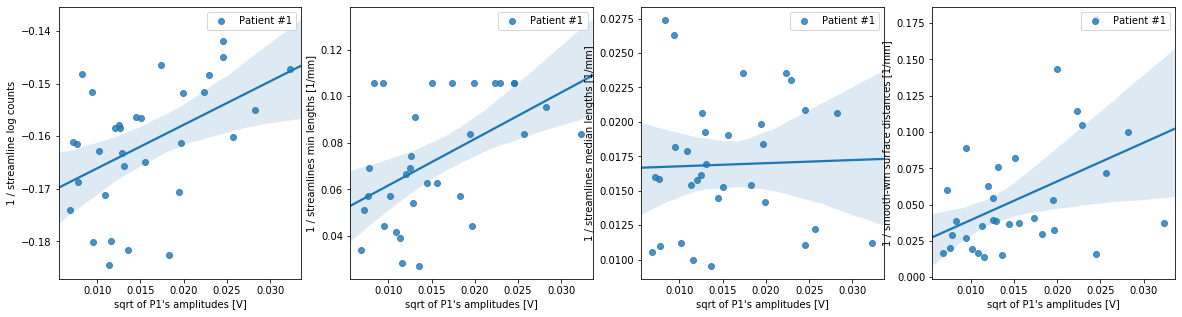

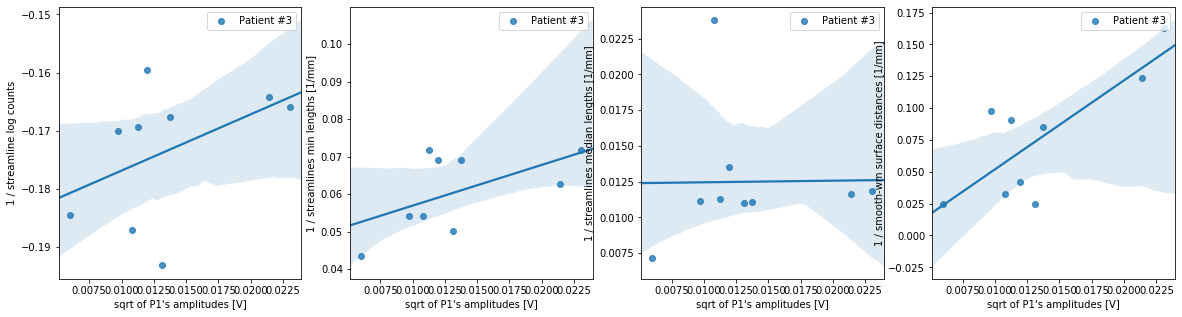

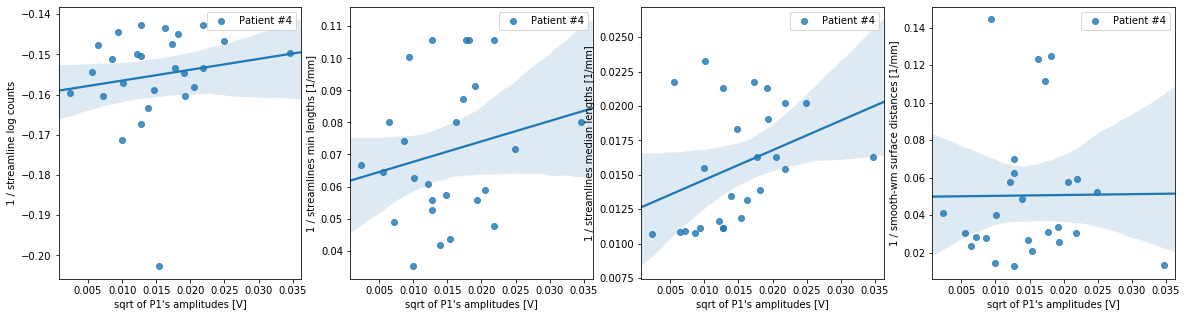

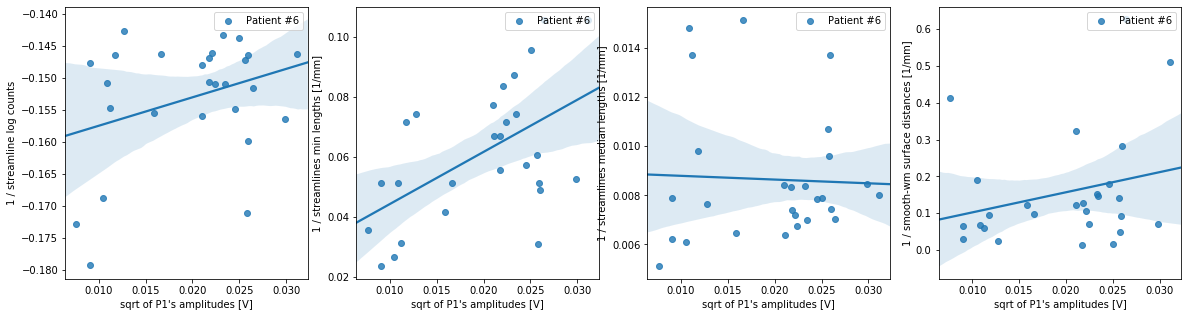

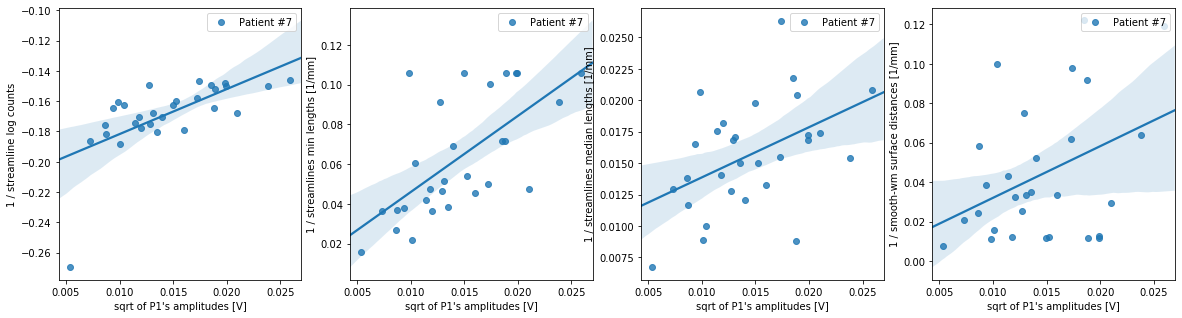

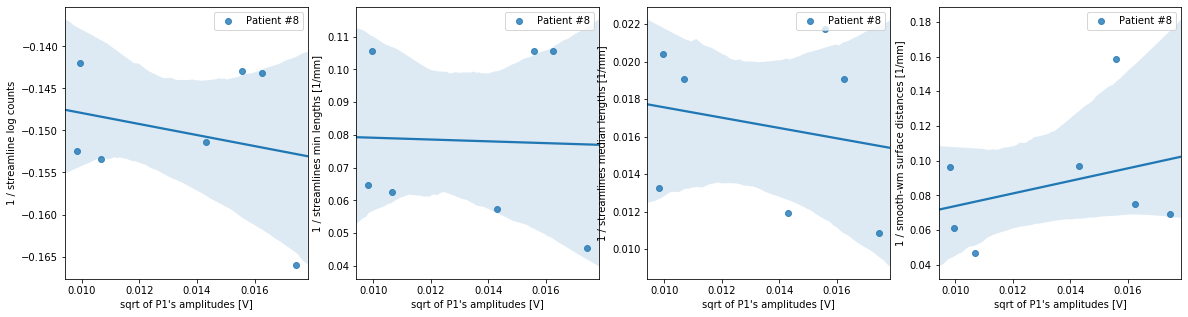

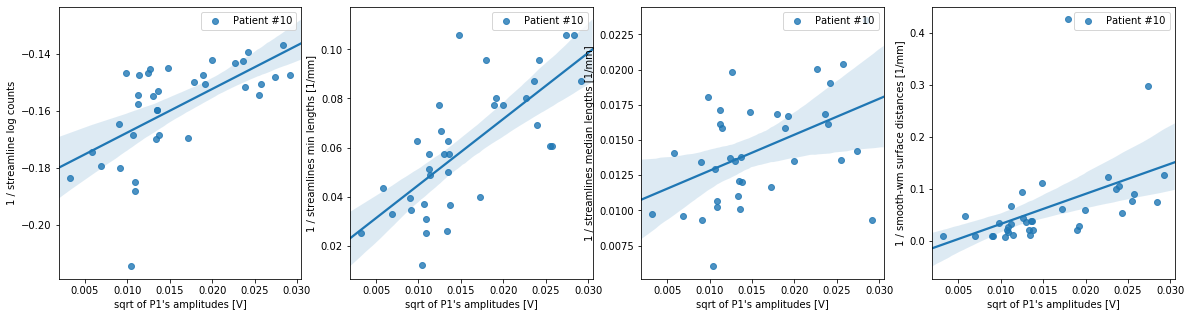

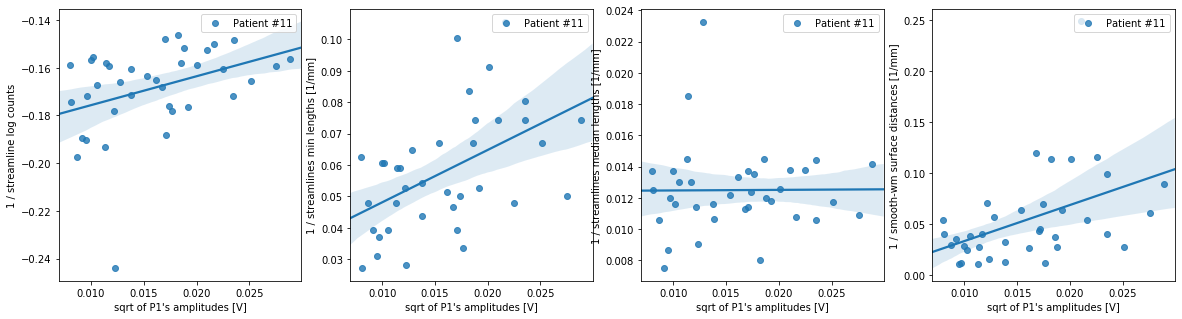

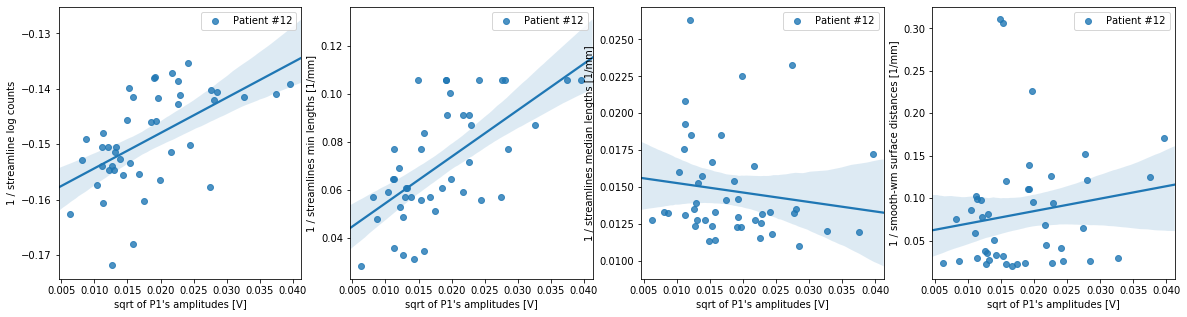

In [14]:
variable_pairs = [

    ['sqrt_amplitudes', 'fibers_minus_log_num_inversed'],
    ['sqrt_amplitudes', 'min_streamlines_lengths_inversed'],
#     ['amplitudes', 'min_streamlines_lengths'],
#     ['amplitudes', 'log_min_streamlines_lengths'],    
#     ['amplitudes', 'max_streamlines_lengths_inversed'],
#     ['amplitudes', 'avg_streamlines_lengths_inversed'],
    ['sqrt_amplitudes', 'median_streamlines_lengths_inversed'],
    ['sqrt_amplitudes', 'smoothwm_surface_distances_inversed'],
#     ['amplitudes', 'pial_surface_distances_inversed'],
#     ['amplitudes', 'intraelectrode_distances_inversed'],
#     ['amplitudes', 'fa_average'],
#     ['amplitudes', 'md_average'],
#     ['amplitudes', 'ad_average'],
#     ['amplitudes', 'rd_average'],   

]

show_scatterplots(data_pd, variable_pairs, masks)

patient	count	del / fib	del / min	del / med	del / smo	
#1	32	0.51, (0.003), 0.64, (0.000), 0.31, (0.086), 0.57, (0.001), 
#3	9	0.07, (0.865), 0.36, (0.346), 0.56, (0.117), -0.14, (0.710), 
#4	26	0.66, (0.000), 0.54, (0.004), -0.23, (0.249), 0.49, (0.012), 
#6	27	0.58, (0.002), 0.66, (0.000), -0.29, (0.145), -0.13, (0.519), 
#7	29	0.69, (0.000), 0.71, (0.000), 0.31, (0.105), 0.25, (0.189), 
#8	7	0.47, (0.284), 0.34, (0.462), 0.21, (0.657), 0.09, (0.847), 
#10	36	0.59, (0.000), 0.60, (0.000), 0.37, (0.027), 0.32, (0.053), 
#11	37	0.42, (0.009), 0.46, (0.004), 0.31, (0.066), 0.40, (0.013), 
#12	44	0.56, (0.000), 0.57, (0.000), -0.40, (0.007), 0.35, (0.019), 
avg: [0.51 0.54 0.13 0.24]
std: [0.17 0.13 0.32 0.24]


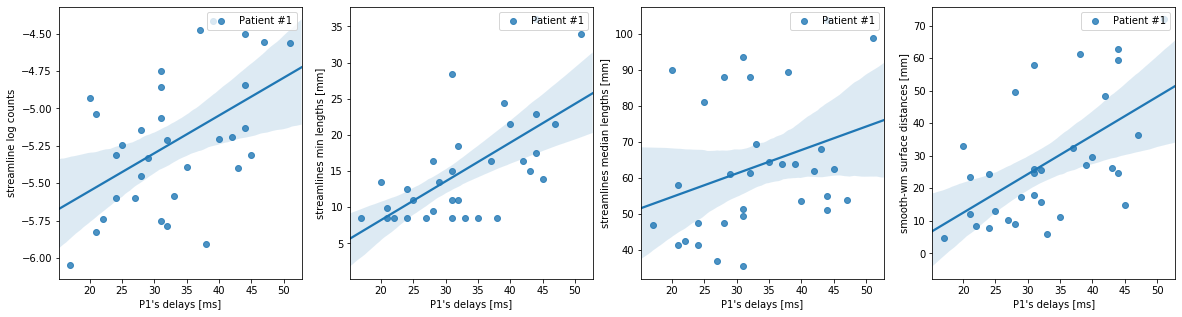

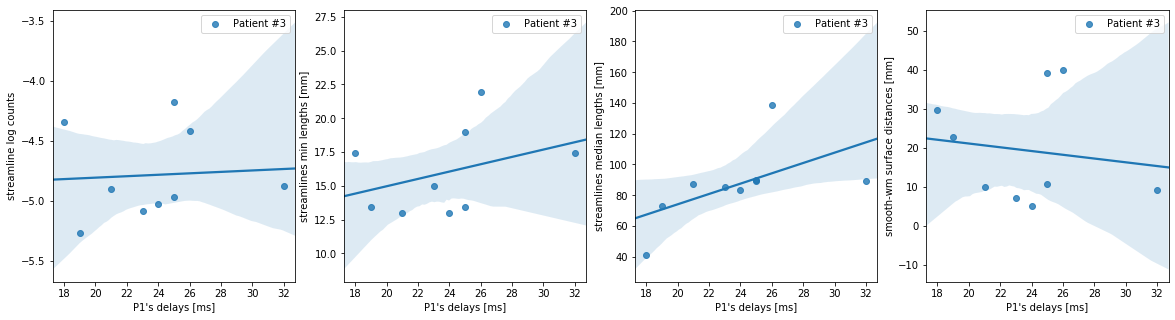

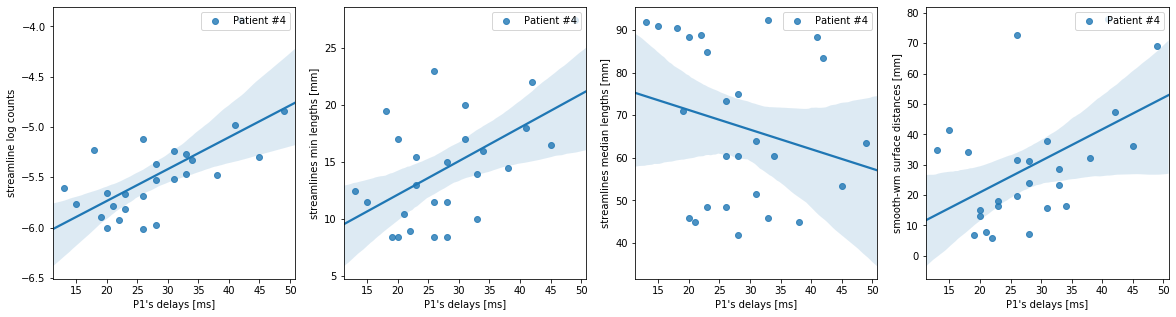

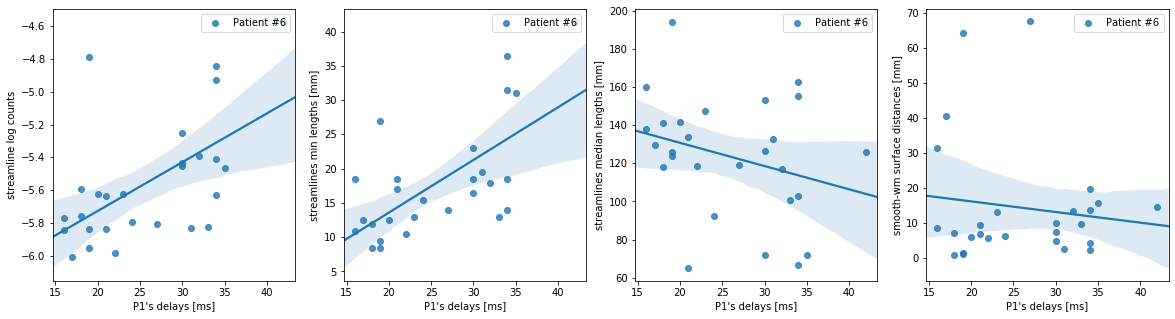

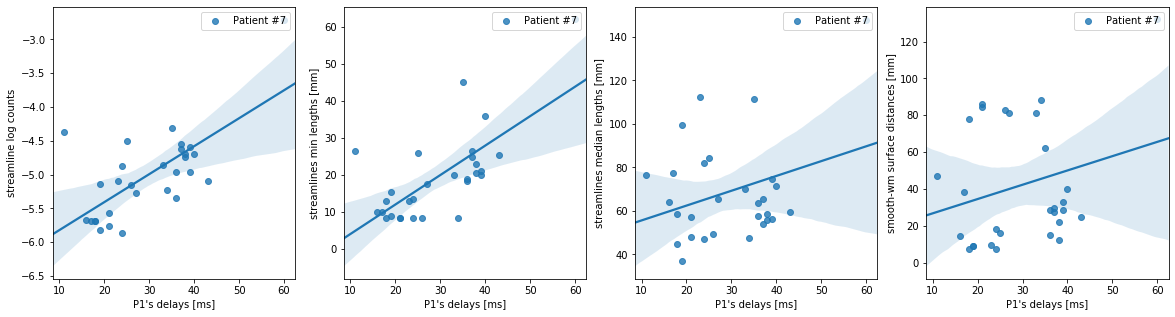

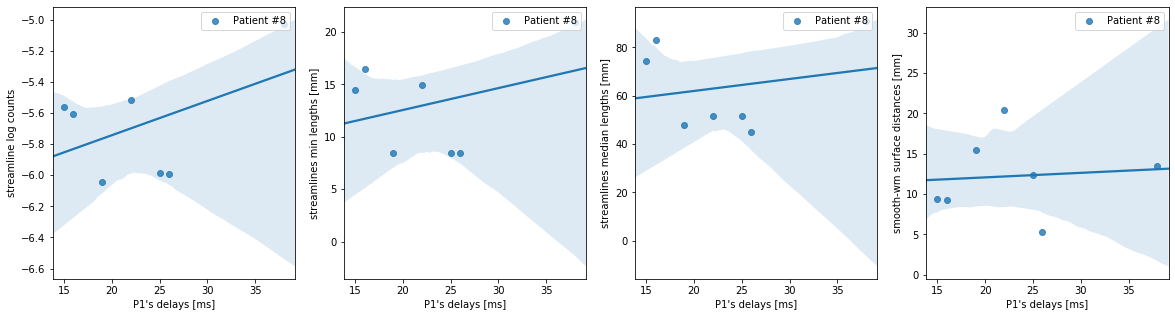

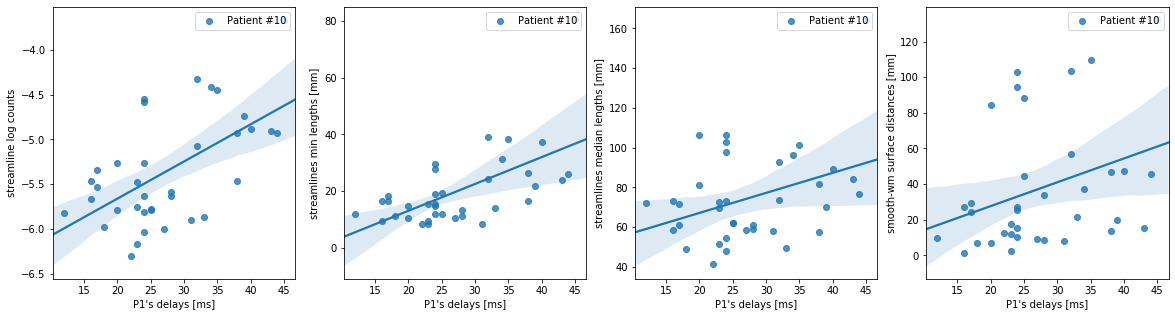

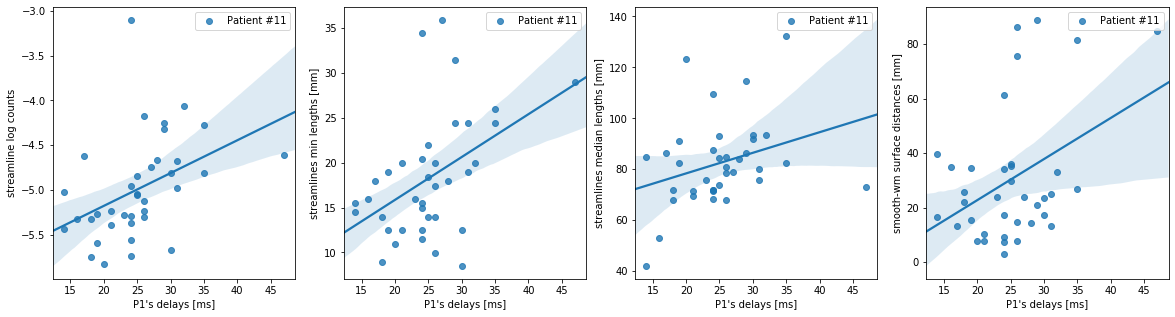

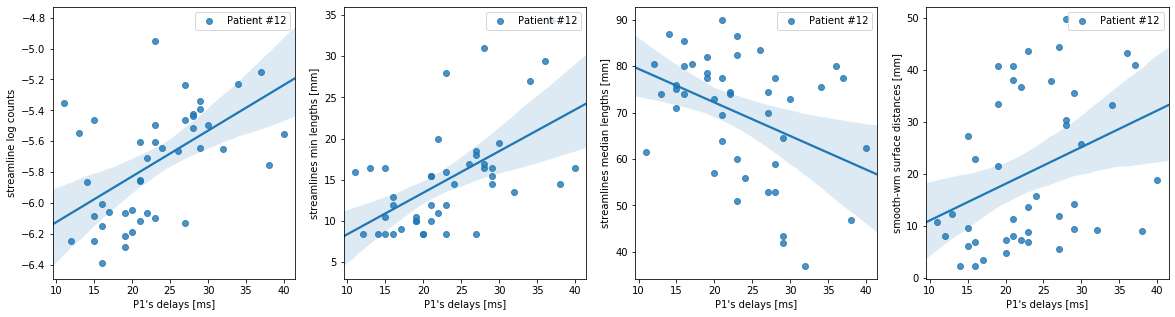

In [15]:
variable_pairs = [

    ['delays', 'fibers_minus_log_num'],
    ['delays', 'min_streamlines_lengths'],
    ['delays', 'median_streamlines_lengths'],
    ['delays', 'smoothwm_surface_distances'],

#     ['delays', 'sqrt_min_streamlines_lengths'],
    
#     ['delays', 'log_min_streamlines_lengths'],
#     ['delays', 'max_streamlines_lengths_trk'],
#     ['delays', 'p10_streamlines_lengths_trk'],
#     ['delays', 'p20_streamlines_lengths_trk'],
#     ['delays', 'p30_streamlines_lengths_trk'],
#     ['delays', 'p40_streamlines_lengths_trk'],    
#     ['delays', 'avg_streamlines_lengths'],
#     ['delays', 'pial_surface_distances'],
#     ['delays', 'intraelectrode_distances'],
#     ['delays', 'fa_average'],
#     ['delays', 'md_average'],
#     ['delays', 'ad_average'],
#     ['delays', 'rd_average'],
#     ['delays', 'rtop_average'],
#     ['delays', 'rtap_average'],
#     ['delays', 'rtpp_average'],
#     ['delays', 'msd_average'],
#     ['delays', 'qiv_average']    
]

show_scatterplots(data_pd, variable_pairs, masks)

# Histograms of measures

patient 1, delays: 33 +/- 8, amplitudes: 285 +/- 240
patient 2, delays: 23 +/- 3, amplitudes: 207 +/- 160
patient 3, delays: 28 +/- 9, amplitudes: 266 +/- 243
patient 4, delays: 25 +/- 7, amplitudes: 436 +/- 257
patient 5, delays: 29 +/- 10, amplitudes: 232 +/- 154
patient 6, delays: 23 +/- 7, amplitudes: 189 +/- 79
patient 7, delays: 27 +/- 8, amplitudes: 291 +/- 236
patient 8, delays: 25 +/- 6, amplitudes: 285 +/- 196
patient 9, delays: 23 +/- 7, amplitudes: 390 +/- 333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

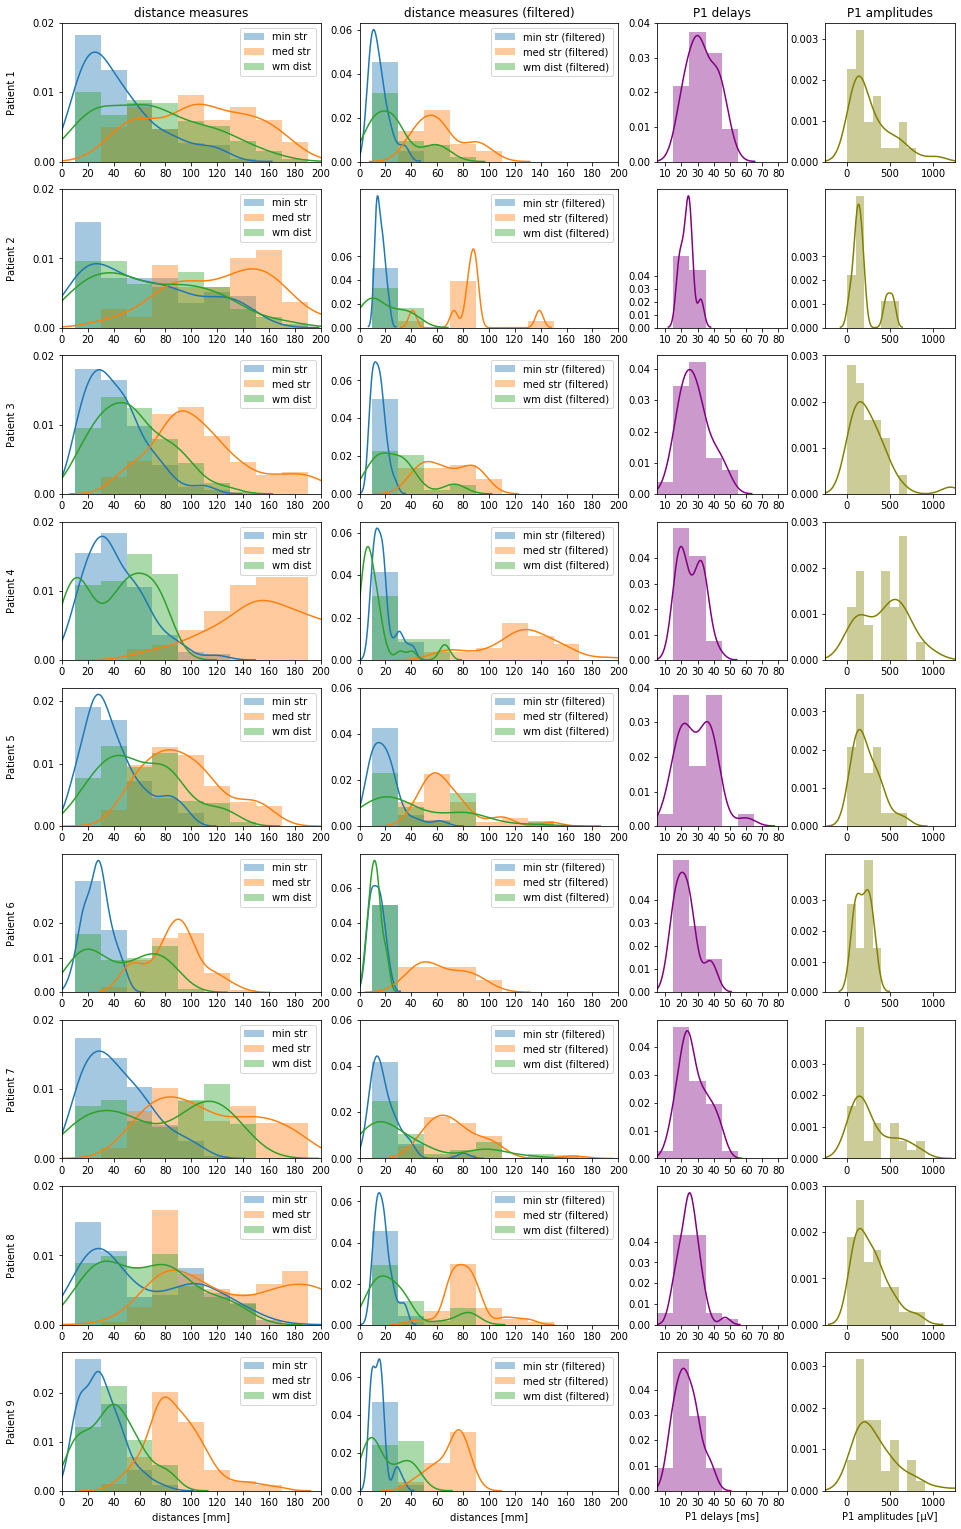

In [16]:
patient_ids = [*data_pd.keys()]

rows_num = len(patient_ids)
cols_num = 4

fig, axs = plt.subplots(
    rows_num, cols_num, figsize = (4 * cols_num, 3 * rows_num),
    gridspec_kw = {'width_ratios': [2, 2, 1, 1]}
)

for row in range(rows_num):

    patient_id = patient_ids[row]

    hist_data = {
        'delays'                     : np.ravel(get_evoked_potential_delay_matrix(data_pd[patient_id])),
        'amplitudes'                 : 1e6 * np.ravel(get_evoked_potential_amplitude_matrix(data_pd[patient_id])),
        'min_streamlines_lengths'    : np.ravel(get_streamlines_min_length_matrix(data_pd[patient_id])),
        'max_streamlines_lengths'    : np.ravel(get_streamlines_max_length_matrix(data_pd[patient_id])),
        'avg_streamlines_lengths'    : np.ravel(get_streamlines_avg_length_matrix(data_pd[patient_id])),
        'median_streamlines_lengths' : np.ravel(get_streamlines_median_length_matrix(data_pd[patient_id])),
        'smoothwm_surface_distances' : np.ravel(get_smoothwm_surface_distance_matrix(data_pd[patient_id])),
        'pial_surface_distances'     : np.ravel(get_pial_surface_distance_matrix(data_pd[patient_id]))
    }

    hist_bins = np.arange(10, 200, 20)

    plt.sca(axs[row, 0])
    sns.distplot(hist_data['min_streamlines_lengths'], bins = hist_bins, label = "min str")
    sns.distplot(hist_data['median_streamlines_lengths'], bins = hist_bins, label = "med str")
    sns.distplot(hist_data['smoothwm_surface_distances'], bins = hist_bins, label = "wm dist")
    
    plt.legend()
    plt.xticks(np.arange(0, 201, 20))
    plt.xlim([0, 200])
    plt.yticks(np.arange(0, 0.03, 0.01))
    plt.ylabel("Patient %d\n" % patient_labels[patient_id])
    
    mask = np.ravel(masks[patient_id])
    for hist_var in hist_data:
        hist_data[hist_var] = hist_data[hist_var][mask]

    plt.sca(axs[row, 1])
    sns.distplot(hist_data['min_streamlines_lengths'], bins = hist_bins, label = "min str (filtered)")
    sns.distplot(hist_data['median_streamlines_lengths'], bins = hist_bins, label = "med str (filtered)")
    sns.distplot(hist_data['smoothwm_surface_distances'], bins = hist_bins, label = "wm dist (filtered)")

    plt.legend()
    plt.xticks(np.arange(0, 201, 20))
    plt.xlim([0, 200])
    plt.yticks(np.arange(0, 0.07, 0.02))
    
    plt.sca(axs[row, 2])
    sns.distplot(hist_data['delays'], bins = np.arange(5, 100, 10), label = "delays", color = "purple")
    plt.xticks(np.arange(10, 81, 10))
    plt.xlim([5, 85])
    plt.yticks(np.arange(0, 0.05, 0.01))
    
    plt.sca(axs[row, 3])
    sns.distplot(hist_data['amplitudes'], bins = np.arange(0, 1000, 100), label = "amplitudes", color = "olive")
    plt.xticks([0, 500, 1000])
    plt.xlim([-250, 1250])
    plt.yticks(np.arange(0, 0.004, 0.001))

    print("patient %d, delays: %d +/- %d, amplitudes: %d +/- %d" % (
        patient_labels[patient_id], 
        np.mean(hist_data['delays']), np.std(hist_data['delays']),
        np.mean(hist_data['amplitudes']), np.std(hist_data['amplitudes'])
    ))
    
plt.sca(axs[0, 0])    
plt.title("distance measures")

plt.sca(axs[0, 1])    
plt.title("distance measures (filtered)")

plt.sca(axs[0, 2])    
plt.title("P1 delays")

plt.sca(axs[0, 3])    
plt.title("P1 amplitudes")

plt.sca(axs[rows_num - 1, 0])    
plt.xlabel("distances [mm]")

plt.sca(axs[rows_num - 1, 1])    
plt.xlabel("distances [mm]")

plt.sca(axs[rows_num - 1, 2])    
plt.xlabel("P1 delays [ms]")

plt.sca(axs[rows_num - 1, 3])    
plt.xlabel("P1 amplitudes [µV]")

plt.savefig("hist_distances_and_delays.pdf", bbox_inches = 'tight')
plt.savefig("hist_distances_and_delays.eps", bbox_inches = 'tight')
    

patient 1, delays: 33 +/- 8, amplitudes: 285 +/- 240
patient 2, delays: 23 +/- 3, amplitudes: 207 +/- 160
patient 3, delays: 28 +/- 9, amplitudes: 266 +/- 243
patient 4, delays: 25 +/- 7, amplitudes: 436 +/- 257
patient 5, delays: 29 +/- 10, amplitudes: 232 +/- 154
patient 6, delays: 23 +/- 7, amplitudes: 189 +/- 79
patient 7, delays: 27 +/- 8, amplitudes: 291 +/- 236
patient 8, delays: 25 +/- 6, amplitudes: 285 +/- 196
patient 9, delays: 23 +/- 7, amplitudes: 390 +/- 333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

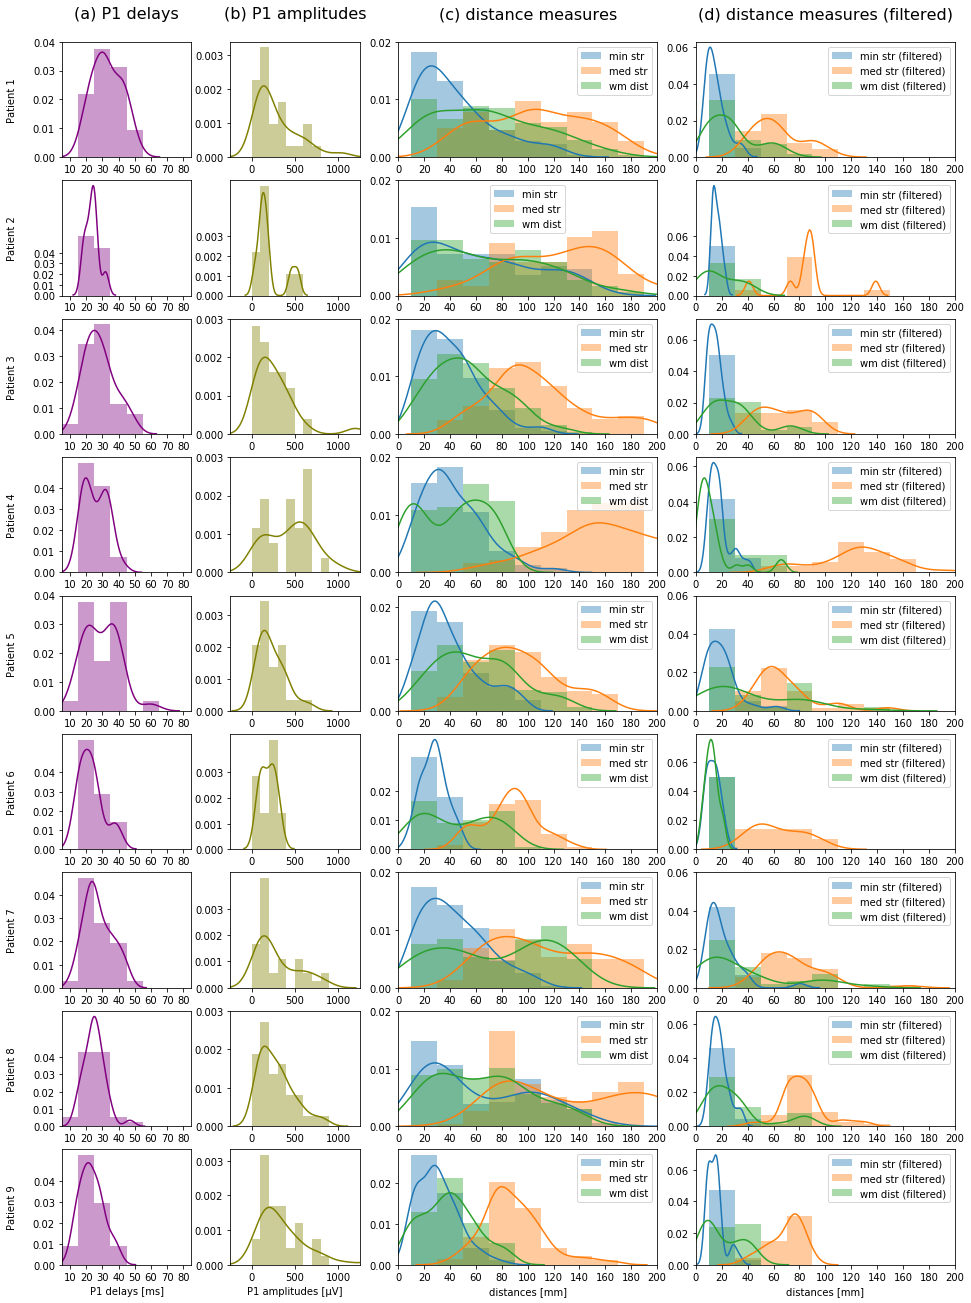

In [37]:
patient_ids = [*data_pd.keys()]

rows_num = len(patient_ids)
cols_num = 4

fig, axs = plt.subplots(
    rows_num, cols_num, figsize = (4 * cols_num, 2.5 * rows_num),
    gridspec_kw = {'width_ratios': [1, 1, 2, 2]}
)

for row in range(rows_num):

    patient_id = patient_ids[row]

    hist_data = {
        'delays'                     : np.ravel(get_evoked_potential_delay_matrix(data_pd[patient_id])),
        'amplitudes'                 : 1e6 * np.ravel(get_evoked_potential_amplitude_matrix(data_pd[patient_id])),
        'min_streamlines_lengths'    : np.ravel(get_streamlines_min_length_matrix(data_pd[patient_id])),
        'max_streamlines_lengths'    : np.ravel(get_streamlines_max_length_matrix(data_pd[patient_id])),
        'avg_streamlines_lengths'    : np.ravel(get_streamlines_avg_length_matrix(data_pd[patient_id])),
        'median_streamlines_lengths' : np.ravel(get_streamlines_median_length_matrix(data_pd[patient_id])),
        'smoothwm_surface_distances' : np.ravel(get_smoothwm_surface_distance_matrix(data_pd[patient_id])),
        'pial_surface_distances'     : np.ravel(get_pial_surface_distance_matrix(data_pd[patient_id]))
    }

    hist_bins = np.arange(10, 200, 20)

    plt.sca(axs[row, 2])
    sns.distplot(hist_data['min_streamlines_lengths'], bins = hist_bins, label = "min str")
    sns.distplot(hist_data['median_streamlines_lengths'], bins = hist_bins, label = "med str")
    sns.distplot(hist_data['smoothwm_surface_distances'], bins = hist_bins, label = "wm dist")
    
    plt.legend()
    plt.xticks(np.arange(0, 201, 20))
    plt.xlim([0, 200])
    plt.yticks(np.arange(0, 0.03, 0.01))
    
    mask = np.ravel(masks[patient_id])
    for hist_var in hist_data:
        hist_data[hist_var] = hist_data[hist_var][mask]

    plt.sca(axs[row, 3])
    sns.distplot(hist_data['min_streamlines_lengths'], bins = hist_bins, label = "min str (filtered)")
    sns.distplot(hist_data['median_streamlines_lengths'], bins = hist_bins, label = "med str (filtered)")
    sns.distplot(hist_data['smoothwm_surface_distances'], bins = hist_bins, label = "wm dist (filtered)")

    plt.legend()
    plt.xticks(np.arange(0, 201, 20))
    plt.xlim([0, 200])
    plt.yticks(np.arange(0, 0.07, 0.02))
    
    plt.sca(axs[row, 0])
    sns.distplot(hist_data['delays'], bins = np.arange(5, 100, 10), label = "delays", color = "purple")
    plt.xticks(np.arange(10, 81, 10))
    plt.xlim([5, 85])
    plt.yticks(np.arange(0, 0.05, 0.01))
    plt.ylabel("Patient %d\n" % patient_labels[patient_id])
    
    plt.sca(axs[row, 1])
    sns.distplot(hist_data['amplitudes'], bins = np.arange(0, 1000, 100), label = "amplitudes", color = "olive")
    plt.xticks([0, 500, 1000])
    plt.xlim([-250, 1250])
    plt.yticks(np.arange(0, 0.004, 0.001))

    print("patient %d, delays: %d +/- %d, amplitudes: %d +/- %d" % (
        patient_labels[patient_id], 
        np.mean(hist_data['delays']), np.std(hist_data['delays']),
        np.mean(hist_data['amplitudes']), np.std(hist_data['amplitudes'])
    ))
    
plt.sca(axs[0, 0])    
plt.title("(a) P1 delays\n", fontsize=16)

plt.sca(axs[0, 1])    
plt.title("(b) P1 amplitudes\n", fontsize=16)

plt.sca(axs[0, 2])    
plt.title("(c) distance measures\n", fontsize=16)

plt.sca(axs[0, 3])    
plt.title("(d) distance measures (filtered)\n", fontsize=16)

plt.sca(axs[rows_num - 1, 2])
plt.xlabel("distances [mm]")

plt.sca(axs[rows_num - 1, 3])
plt.xlabel("distances [mm]")

plt.sca(axs[rows_num - 1, 0])
plt.xlabel("P1 delays [ms]")

plt.sca(axs[rows_num - 1, 1])
plt.xlabel("P1 amplitudes [µV]")

plt.savefig("hist_distances_and_delays.pdf", bbox_inches = 'tight')
plt.savefig("hist_distances_and_delays.eps", bbox_inches = 'tight')
    

# Streamlines count vs. P1's amplitude

Patient #1 (r-corr, p-value): (0.5417895168428336, 0.0013614951562766595)
Patient #3 (r-corr, p-value): (0.3952185655294586, 0.29244011264035097)
Patient #4 (r-corr, p-value): (0.177628006907511, 0.38533014462615855)
Patient #6 (r-corr, p-value): (0.14925624852960456, 0.45745917037192363)
Patient #7 (r-corr, p-value): (0.7302126770877392, 6.912329454015427e-06)
Patient #8 (r-corr, p-value): (-0.07419487243739539, 0.8743892754468003)
Patient #10 (r-corr, p-value): (0.6268036426522279, 4.30981546573197e-05)
Patient #11 (r-corr, p-value): (0.33511601226196136, 0.0426097436914282)
Patient #12 (r-corr, p-value): (0.5262348196092546, 0.00024353540054710811)


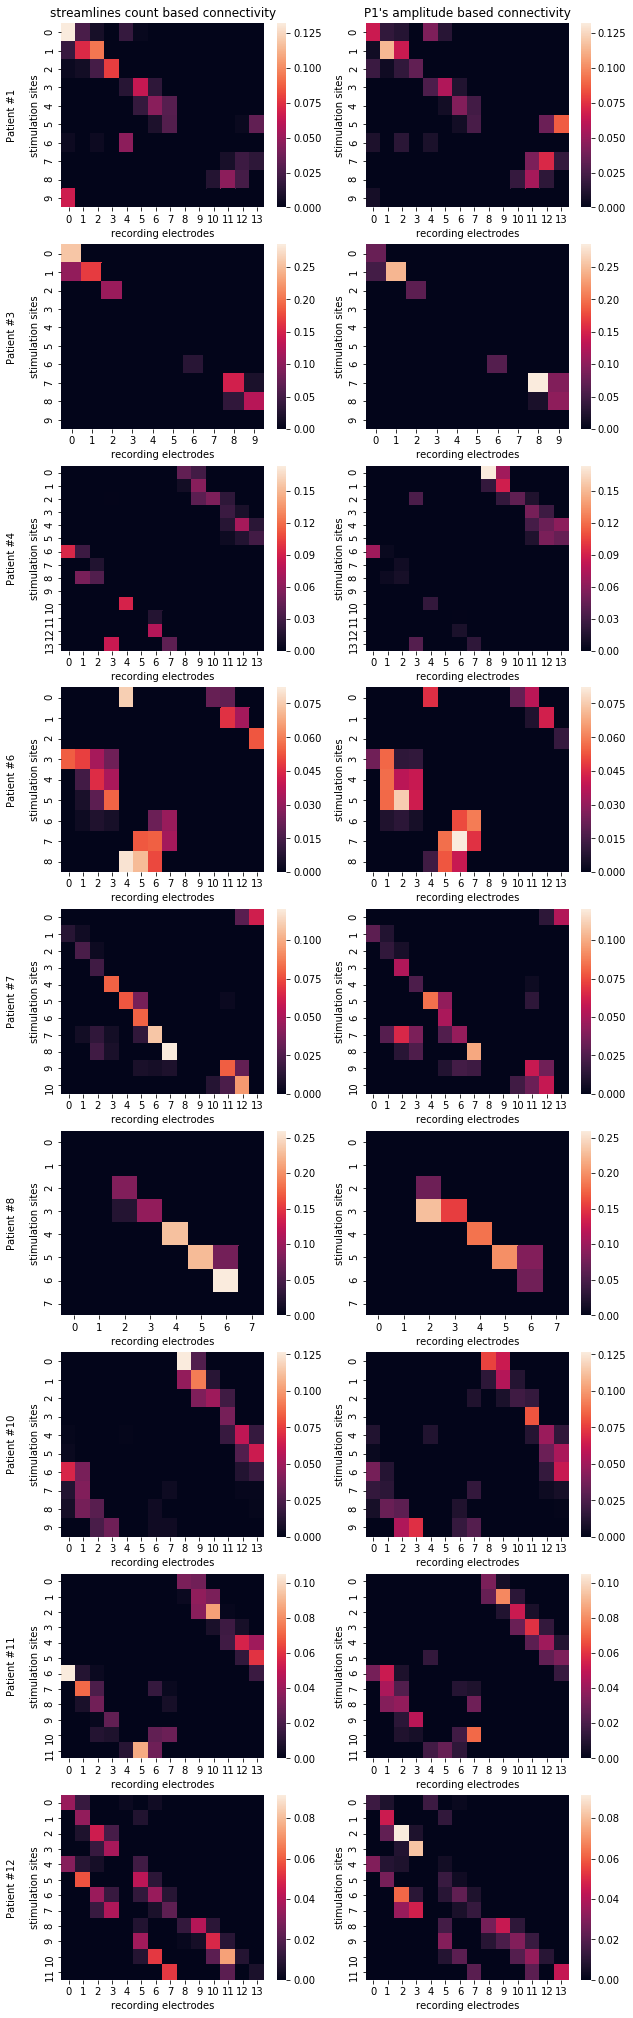

In [18]:
patient_ids = sorted(data_pd.keys())
patients_num = len(patient_ids)

_, ax = plt.subplots(patients_num, 2, figsize=(10, 4 * patients_num))

for i in range(patients_num):

    patient_id = patient_ids[i]
    
    structural_connectivity_matrix = get_count_based_connectivity_matrix(
        data_pd[patient_id], masks[patient_id]
    )
    functional_connectivity_matrix = get_amplitude_based_connectivity_matrix(
        data_pd[patient_id], masks[patient_id]
    )
    
    v_min = np.minimum(np.min(structural_connectivity_matrix), np.min(functional_connectivity_matrix))
    v_max = np.maximum(np.max(structural_connectivity_matrix), np.max(functional_connectivity_matrix))
    
    print("Patient #%d (r-corr, p-value): %s" % (
        patient_id, pearsonr(
            np.ravel(structural_connectivity_matrix[masks[patient_id] > 0]), 
            np.ravel(functional_connectivity_matrix[masks[patient_id] > 0])
        )
    ))
    
    plt.sca(ax[i, 0])
    sns.heatmap(structural_connectivity_matrix, vmin=v_min, vmax=v_max, linewidths=0.0)
    plt.ylabel("Patient #%d\n\nstimulation sites" % patient_id)
    plt.xlabel("recording electrodes")
    if i == 0:
        plt.title("streamlines count based connectivity")

    plt.sca(ax[i, 1])
    sns.heatmap(functional_connectivity_matrix, vmin=v_min, vmax=v_max, linewidths=0.0)
    plt.xlabel("recording electrodes")
    plt.ylabel("stimulation sites")
    if i == 0:
        plt.title("P1's amplitude based connectivity")

plt.savefig("streamlines_count_vs_p1_amplitude.pdf")

# Streamlines length vs. P1's delay

Patient #1 (r-corr, p-value): (-0.6497922207438238, 5.7057323692825574e-05)
Patient #3 (r-corr, p-value): (-0.3610642508881379, 0.3397419191163391)
Patient #4 (r-corr, p-value): (-0.487227375870642, 0.01158558342461586)
Patient #6 (r-corr, p-value): (-0.6500972861265265, 0.0002421077834100297)
Patient #7 (r-corr, p-value): (-0.635234570033081, 0.00021371909889425237)
Patient #8 (r-corr, p-value): (-0.1546813322633659, 0.7405349751749007)
Patient #10 (r-corr, p-value): (-0.5635296590025013, 0.000345237146915336)
Patient #11 (r-corr, p-value): (-0.38206368404340896, 0.01961953523671303)
Patient #12 (r-corr, p-value): (-0.5679878332585475, 5.7840424802923607e-05)


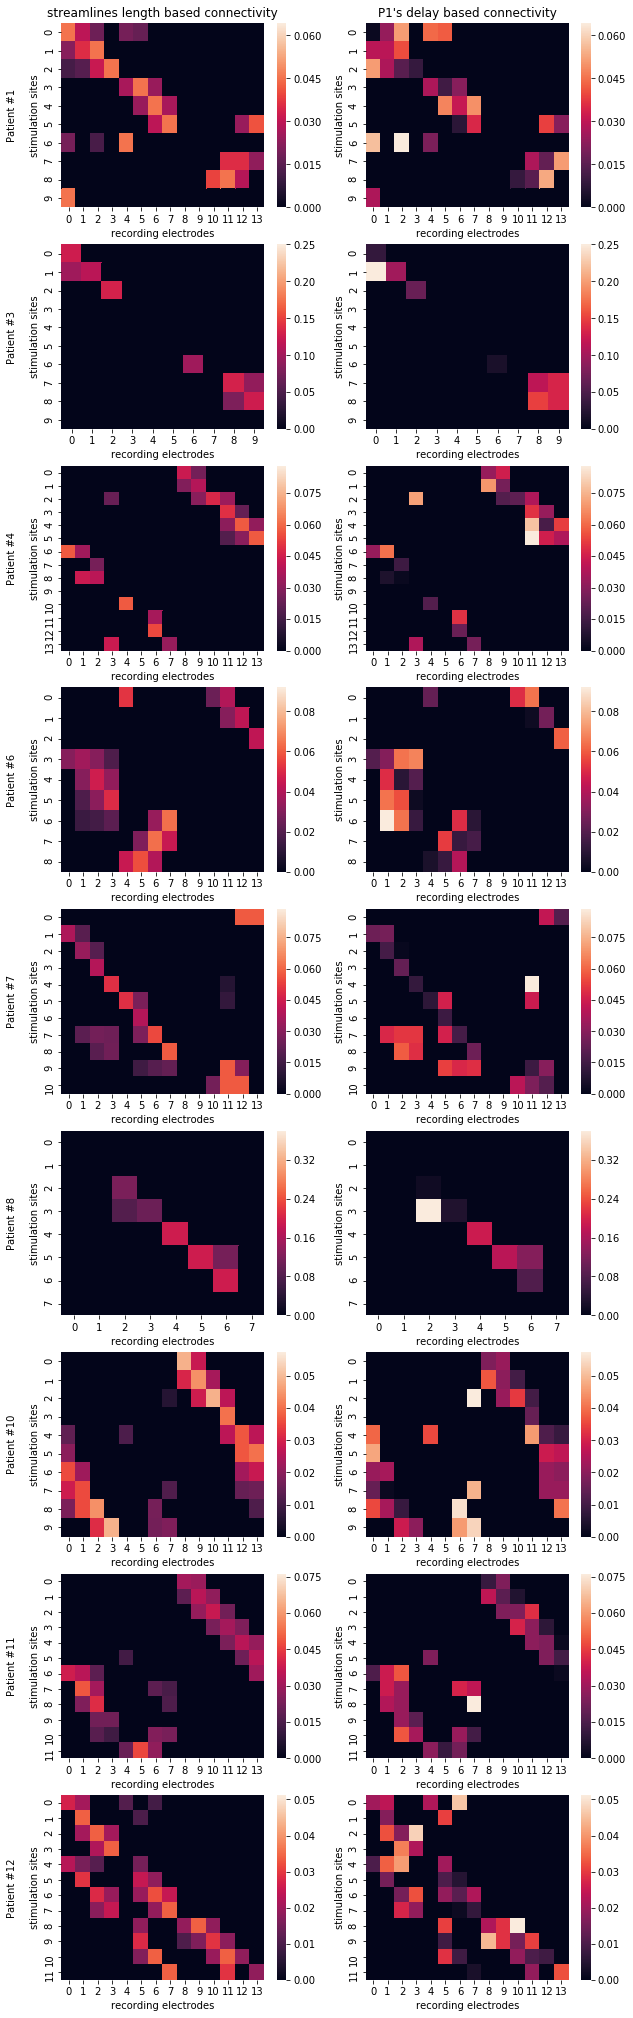

In [19]:
patient_ids = sorted(data_pd.keys())
patients_num = len(patient_ids)

_, ax = plt.subplots(patients_num, 2, figsize=(10, 4 * patients_num))

for i in range(patients_num):

    patient_id = patient_ids[i]
    
    structural_connectivity_matrix = get_inversed_streamlines_min_length_based_connectivity_matrix(
        data_pd[patient_id], masks[patient_id]
    )
    functional_connectivity_matrix = get_delay_based_connectivity_matrix(
        data_pd[patient_id], masks[patient_id]
    )
    
    v_min = np.minimum(np.min(structural_connectivity_matrix), np.min(functional_connectivity_matrix))
    v_max = np.maximum(np.max(structural_connectivity_matrix), np.max(functional_connectivity_matrix))
    
    print("Patient #%d (r-corr, p-value): %s" % (
        patient_id, pearsonr(
            np.ravel(structural_connectivity_matrix[masks[patient_id] > 0]), 
            np.ravel(functional_connectivity_matrix[masks[patient_id] > 0])
        )
    ))
    
    plt.sca(ax[i, 0])
    sns.heatmap(structural_connectivity_matrix, vmin=v_min, vmax=v_max)
    plt.ylabel("Patient #%d\n\nstimulation sites" % patient_id)
    plt.xlabel("recording electrodes")
    if i == 0:
        plt.title("streamlines length based connectivity")

    plt.sca(ax[i, 1])
    sns.heatmap(functional_connectivity_matrix, vmin=v_min, vmax=v_max)
    plt.xlabel("recording electrodes")
    plt.ylabel("stimulation sites")
    if i == 0:
        plt.title("P1's delay based connectivity")

plt.savefig("streamlines_length_vs_p1_delay.pdf")

In [20]:
def show_regression_results(x_data, y_data, regr, pred_y_data = None):
    
    plt.scatter(x_data, y_data)
    
    if not pred_y_data is None:
        plt.scatter(x_data, pred_y_data)
    
#     plot_range = [np.min(x_data), np.max(x_data)]
#     plt.plot(
#         plot_range, np.ravel(regr.coef_) * plot_range + np.ravel(regr.intercept_)
#     )    
    

def train_regression_model(
    data_pd, masks, x_fun, y_fun, x_label, y_label, train_patient_ids, test_patient_ids = None
):
    
    train_x_data = []
    train_y_data = []
    
    for train_patient_id in train_patient_ids:
        
        x_data_matrix = x_fun(data_pd[train_patient_id])
        y_data_matrix = y_fun(data_pd[train_patient_id])
        
        train_x_data.extend(x_data_matrix[masks[train_patient_id]])
        train_y_data.extend(y_data_matrix[masks[train_patient_id]])
      
    train_x_data = np.array(train_x_data).reshape(-1, 1)
    train_y_data = np.array(train_y_data).reshape(-1, 1)
            
    test_x_data = []
    test_y_data = []
        
    if test_patient_ids is None:
        test_patient_ids = set(data_pd.keys()) - set(train_patient_ids)
        
    for test_patient_id in test_patient_ids:
        
        x_data_matrix = x_fun(data_pd[test_patient_id])
        y_data_matrix = y_fun(data_pd[test_patient_id])
        
        test_x_data.extend(x_data_matrix[masks[test_patient_id]])
        test_y_data.extend(y_data_matrix[masks[test_patient_id]])
        
    test_x_data = np.array(test_x_data).reshape(-1, 1)
    test_y_data = np.array(test_y_data).reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(train_x_data, train_y_data)
    
    ref_regr = linear_model.LinearRegression()
    ref_regr.fit(test_x_data, test_y_data)
    
    pred_y_data = regr.predict(test_x_data)
    
    train_label = "Trained on Patients: %s" % sorted(train_patient_ids)
    test_label = "Tested on Patients: %s" % sorted(test_patient_ids)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title(train_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    show_regression_results(train_x_data, train_y_data, regr)
    
    plt.subplot(1, 2, 2)
    plt.title(test_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    show_regression_results(test_x_data, test_y_data, regr, pred_y_data)
    
#     plot_range = [np.min(test_x_data), np.max(test_x_data)]
#     plt.plot(
#         plot_range, np.ravel(ref_regr.coef_) * plot_range + np.ravel(ref_regr.intercept_)
#     )
    
    plt.legend(['reference', 'predicted'])
    plt.savefig("regression_%d.pdf" % test_patient_ids[0])
    
    squared_error = (test_y_data - pred_y_data) ** 2
    
    print("%s, %s, RMSE: %.1f +/- %.2f" % (
        train_label, test_label, np.sqrt(np.mean(squared_error)), np.sqrt(np.std(squared_error))
    ))


Trained on Patients: [1, 4, 7], Tested on Patients: [10], RMSE: 9.4 +/- 11.43


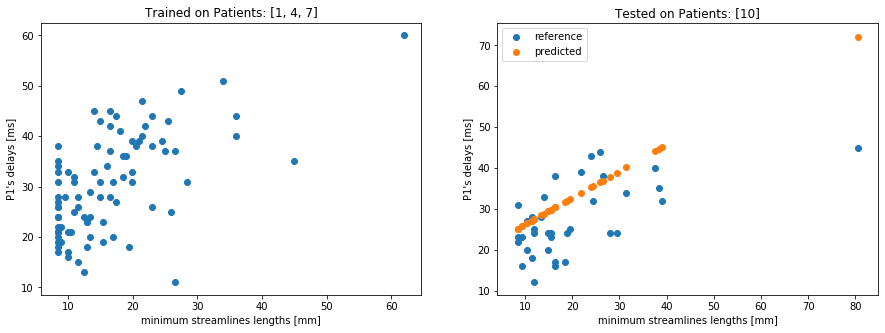

In [21]:
batch_patient_ids = [
    [ [1, 4, 7], [10] ]
#     [ [1, 4, 6], [7] ],
#     [ [1, 4, 7], [6] ],
#     [ [1, 6, 7], [4] ],
#     [ [4, 6, 7], [1] ]
]


for batch in batch_patient_ids:

    train_regression_model(
        data_pd, masks, 
#         get_streamlines_min_length_based_connectivity_matrix, get_delay_based_connectivity_matrix,
        get_streamlines_min_length_matrix, get_evoked_potential_delay_matrix,
        "minimum streamlines lengths [mm]", "P1's delays [ms]", 
        batch[0], batch[1]
    )

Trained on Patients: [1, 4, 7], Tested on Patients: [10], RMSE: 195.9 +/- 255.56


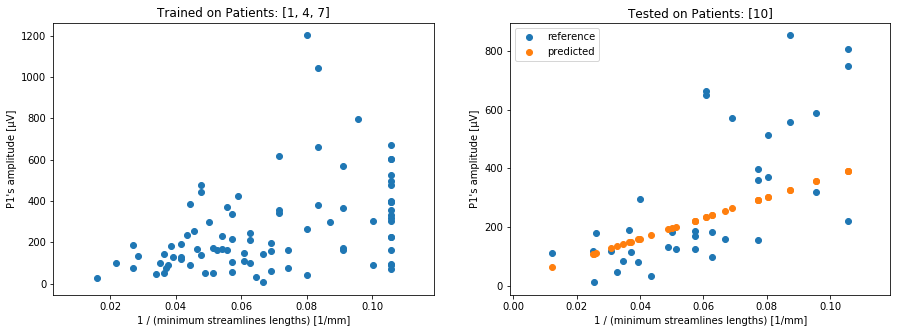

In [22]:
batch_patient_ids = [
    [ [1, 4, 7], [10] ]
#     [ [1, 4, 6], [7] ],
#     [ [1, 4, 7], [6] ],
#     [ [1, 6, 7], [4] ],
#     [ [4, 6, 7], [1] ]
]

def get_amplitude(data_pd):
    return 1e6 * get_evoked_potential_amplitude_matrix(data_pd)

def get_inversed_distance(data_pd):
    return 1 / (1 + get_streamlines_min_length_matrix(data_pd))

for batch in batch_patient_ids:

    train_regression_model(
        data_pd, masks, 
        get_inversed_distance, get_amplitude,
        "1 / (minimum streamlines lengths) [1/mm]", "P1's amplitude [µV]", 
        batch[0], batch[1]
    )

In [23]:
def get_batch_patient_ids(eval_patient_id, patient_dataset_ids = [1, 4, 6, 7, 10]):

    train_test_patient_ids = patient_dataset_ids.copy() 
    train_test_patient_ids.remove(eval_patient_id)

    batch_patient_ids = []

    for test_patient_id in train_test_patient_ids:
        train_patient_ids = train_test_patient_ids.copy()
        train_patient_ids.remove(test_patient_id)
        batch_patient_ids.append([train_patient_ids, [test_patient_id]])

    return batch_patient_ids


In [24]:
# batch_patient_ids = [
#     [ [1, 4, 6,  7], [10] ],
#     [ [1, 4, 6, 10], [ 7] ],
#     [ [1, 4, 7, 10], [ 6] ],
#     [ [1, 6, 7, 10], [ 4] ],
#     [ [4, 6, 7, 10], [ 1] ],
# ]

eval_patient_id = 1
batch_patient_ids = get_batch_patient_ids(eval_patient_id)


In [25]:
def fix_dim(data):

    data = np.array(data)
    if data.ndim < 2:
        data = data.reshape(-1, 1)
    return data


def train_regression_model_of_delays(train_x, train_y, test_x, test_y):
    
    regr = linear_model.LinearRegression()
#     regr = svm.SVR(C=1.0, epsilon=0.2) # gamma='scale', C=1.0, epsilon=0.2)
#     regr = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3)

    regr.fit(train_x, train_y)
    pred_y = regr.predict(test_x)
    
#     regression_score = regr.score(test_x, test_y)
    regression_score = r2_score(test_y, pred_y)
#     print("Score=%.2f" % regression_score, end = '\t')

    squared_error = (test_y - pred_y) ** 2
    dummy_squared_error = (test_y - np.mean(train_y)) ** 2

    aic = 2 * train_x.shape[1] + 2 * np.log(np.mean(squared_error))
    bic = np.log(len(test_y)) * train_x.shape[1] + 2 * np.log(np.mean(squared_error))
    
    sns.distplot(np.sqrt(squared_error))

    rmse = np.sqrt(np.mean(squared_error))
    rmse_std = np.sqrt(np.std(squared_error))
    
    dummy_rmse = np.sqrt(np.mean(dummy_squared_error))
    dummy_rmse_std = np.sqrt(np.std(dummy_squared_error))
    
#     print("RMSE +/- STD = %.0f +/- %.1f\tdummy RMSE +/- STD = %.0f +/- %.1f" % (
#         rmse, rmse_std, dummy_rmse, dummy_rmse_std
#     ), end="\t")
    
    return [regression_score, rmse, rmse_std, dummy_rmse, dummy_rmse_std, aic, bic, regr.coef_[0], regr.intercept_], regr.coef_
    
    
def train_regression_model_of_amplitudes(train_x, train_y, test_x, test_y):
    
    regr = linear_model.LinearRegression()
#     regr = svm.SVR(C=1.0, epsilon=0.2) # gamma='scale', C=1.0, epsilon=0.2)
#     regr = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3)

    regr.fit(train_x, train_y)
    pred_y = regr.predict(test_x)
    
#     regression_score = regr.score(test_x, test_y)
    regression_score = r2_score(test_y, pred_y)
#     print("Score=%.2f" % regression_score, end = '\t')

    squared_error = ((np.array(test_y) ** 2) - (np.array(pred_y) ** 2)) ** 2
    dummy_squared_error = 0

    aic = 2 * train_x.shape[1] + 2 * np.log(np.mean(squared_error))
    bic = np.log(len(test_y)) * train_x.shape[1] + 2 * np.log(np.mean(squared_error))
    
    sns.distplot(np.sqrt(squared_error))

    rmse = np.sqrt(np.mean(squared_error))
    rmse_std = np.sqrt(np.std(squared_error))
    
    dummy_rmse = np.sqrt(np.mean(dummy_squared_error))
    dummy_rmse_std = np.sqrt(np.std(dummy_squared_error))
    
#     print("RMSE +/- STD = %.0f +/- %.1f\tdummy RMSE +/- STD = %.0f +/- %.1f" % (
#         rmse, rmse_std, dummy_rmse, dummy_rmse_std
#     ), end="\t")
    
    return [regression_score, rmse, rmse_std, dummy_rmse, dummy_rmse_std, aic, bic, regr.coef_[0], regr.intercept_], regr.coef_
        
    

# Prediction of delays

In [26]:
def get_delay_features(patient_ids, feature_names):
    
    x = None
    y = []

    for patient_id in patient_ids:

        features = {}

        # streamlines min length
        structural_connectivity_matrix = get_streamlines_min_length_matrix(data_pd[patient_id])
        features['streamlines_min_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines log min length
        structural_connectivity_matrix = get_streamlines_log_min_length_matrix(data_pd[patient_id])
        features['streamlines_log_min_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines sqrt min length
        structural_connectivity_matrix = get_streamlines_sqrt_min_length_matrix(data_pd[patient_id])
        features['streamlines_sqrt_min_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines max length
        structural_connectivity_matrix = get_streamlines_max_length_matrix(data_pd[patient_id])
        features['streamlines_max_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines avg length
        structural_connectivity_matrix = get_streamlines_avg_length_matrix(data_pd[patient_id])
        features['streamlines_avg_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines median length
        structural_connectivity_matrix = get_streamlines_median_length_matrix(data_pd[patient_id])
        features['streamlines_median_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines std length
        structural_connectivity_matrix = get_streamlines_std_length_matrix(data_pd[patient_id])
        features['streamlines_std_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines count
        structural_connectivity_matrix = get_streamlines_count_matrix(data_pd[patient_id])
        features['streamlines_count'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines log count
        structural_connectivity_matrix = get_streamlines_log_count_matrix(data_pd[patient_id])
        features['streamlines_log_count'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines minus log count
        structural_connectivity_matrix = -get_streamlines_log_count_matrix(data_pd[patient_id])
        features['streamlines_minus_log_count'] = structural_connectivity_matrix[masks[patient_id]]

        # smoothwm surface distance
        structural_connectivity_matrix = get_smoothwm_surface_distance_matrix(data_pd[patient_id])
        features['smoothwm_surface_distance'] = structural_connectivity_matrix[masks[patient_id]]

        # pial surface distance
        structural_connectivity_matrix = get_pial_surface_distance_matrix(data_pd[patient_id])
        features['pial_surface_distance'] = structural_connectivity_matrix[masks[patient_id]]

        # intraelectrode distance
        structural_connectivity_matrix = get_intraelectrode_distance_matrix(
            electrode_locations[patient_id], stimulation_site_locations[patient_id]
        )
        features['intraelectrode_distance'] = structural_connectivity_matrix[masks[patient_id]]
                
        # fa average
        structural_connectivity_matrix = get_mean_fa_matrix(data_pd[patient_id])
        features['fa_average'] = structural_connectivity_matrix[masks[patient_id]]

        # md average
        structural_connectivity_matrix = get_mean_md_matrix(data_pd[patient_id])
        features['md_average'] = structural_connectivity_matrix[masks[patient_id]]

        # ad average
        structural_connectivity_matrix = get_mean_ad_matrix(data_pd[patient_id])
        features['ad_average'] = structural_connectivity_matrix[masks[patient_id]]

        # rd average
        structural_connectivity_matrix = get_mean_rd_matrix(data_pd[patient_id])
        features['rd_average'] = structural_connectivity_matrix[masks[patient_id]]

        # rtop average
        structural_connectivity_matrix = get_mean_rtop_matrix(data_pd[patient_id])
        features['rtop_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # rtap average
        structural_connectivity_matrix = get_mean_rtap_matrix(data_pd[patient_id])
        features['rtap_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # rtpp average
        structural_connectivity_matrix = get_mean_rtpp_matrix(data_pd[patient_id])
        features['rtpp_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # msd average
        structural_connectivity_matrix = get_mean_msd_matrix(data_pd[patient_id])
        features['msd_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # qiv average
        structural_connectivity_matrix = get_mean_qiv_matrix(data_pd[patient_id])
        features['qiv_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # ng average
        structural_connectivity_matrix = get_mean_ng_matrix(data_pd[patient_id])
        features['ng_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # ng_perp average
        structural_connectivity_matrix = get_mean_ng_perp_matrix(data_pd[patient_id])
        features['ng_perp_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # ng average
        structural_connectivity_matrix = get_mean_ng_par_matrix(data_pd[patient_id])
        features['ng_par_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        feature_matrix = None
        for feature_name in feature_names:
            
            if feature_matrix is None:
                feature_matrix = features[feature_name]
            else:
                feature_matrix = np.c_[feature_matrix, features[feature_name]]
            
        if x is None:
            x = feature_matrix
        else:
            x = np.r_[x, feature_matrix]

        effective_connectivity_matrix = get_evoked_potential_delay_matrix(data_pd[patient_id])
        y.extend(effective_connectivity_matrix[masks[patient_id]])

    return x, y
    


Trained on Patients: [4, 6, 7], Tested on Patients: [1]
   score   coef  rmse  rmse_std features
0   0.07  10.76   9.0       9.0      [0]
1  -0.15   0.62   9.0      10.0      [1]
2  -0.29  -0.03  10.0      11.0      [2]
3  -0.16   0.10  10.0      10.0      [3]
   score   coef  rmse  rmse_std       features
0  -2.48  11.86  17.0      15.0  [0, 5, 6, 12]
1  -0.66   0.63  11.0      11.0  [1, 5, 6, 12]
2  -1.93  -0.04  15.0      16.0  [2, 5, 6, 12]
3   0.20   0.12   8.0       8.0  [3, 5, 6, 12]

Trained on Patients: [1, 6, 7], Tested on Patients: [4]
   score   coef  rmse  rmse_std features
0   0.40  10.63   7.0       8.0      [0]
1   0.24   0.59   8.0       8.0      [1]
2  -0.02  -0.03   9.0       9.0      [2]
3   0.14   0.11   8.0       9.0      [3]
   score   coef  rmse  rmse_std       features
0   0.33  11.08   7.0       9.0  [0, 5, 6, 12]
1   0.04   0.66   9.0      10.0  [1, 5, 6, 12]
2   0.00  -0.00   9.0      10.0  [2, 5, 6, 12]
3   0.16   0.14   8.0       9.0  [3, 5, 6, 12]

Train

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

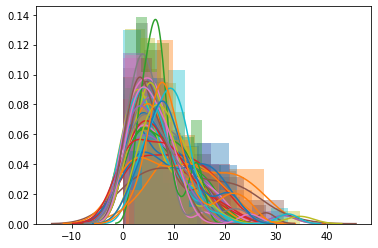

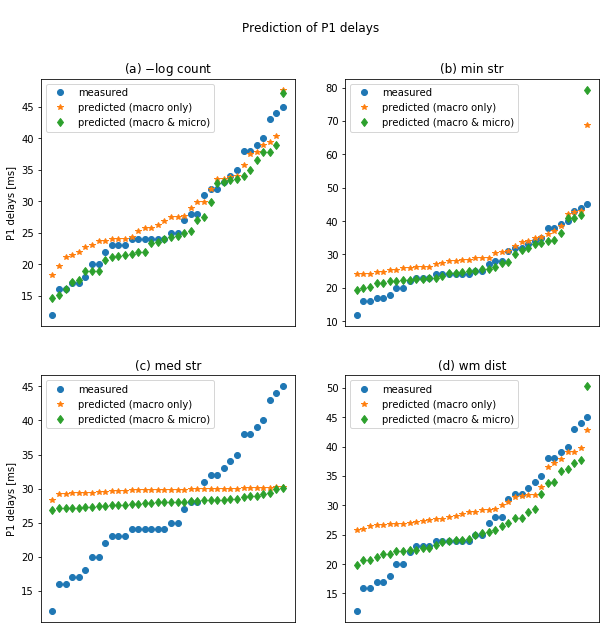

In [27]:
input_variables = [

  'streamlines_minus_log_count',   # 0
  'streamlines_min_length',        # 1
  'streamlines_median_length',     # 2
  'smoothwm_surface_distance',     # 3
  
  'fa_average',                    # 4
  'md_average',                    # 5
  'ad_average',                    # 6
  'rd_average',                    # 7
    
  'rtop_average',                  # 8
  'rtap_average',                  # 9
  'rtpp_average',                  # 10
  'msd_average',                   # 11
  'qiv_average',                   # 12

  'intraelectrode_distance'        # 13

]

eval_patient_id = 10

features_ids = [
    [ [0], [0, 5, 6, 12] ],
    [ [1], [1, 5, 6, 12] ],
    [ [2], [2, 5, 6, 12] ],
    [ [3], [3, 5, 6, 12] ],
]

dist_only_coefs = []
dist_only_intercepts = []

dist_and_micro_coefs = []
dist_and_micro_intercepts = []

for batch in get_batch_patient_ids(eval_patient_id):

    batch_dist_and_micro_coefs = []
    
    train_x, train_y = get_delay_features(batch[0], input_variables)
    test_x, test_y = get_delay_features(batch[1], input_variables)
    
    print("\nTrained on Patients: %s, Tested on Patients: %s" % (sorted(batch[0]), sorted(batch[1])))
    
    dist_only_accuracy = []
    dist_and_micro_accuracy = []
    
    for features_pair in features_ids:

        # distances only        
        result, _ = train_regression_model_of_delays(train_x[:, features_pair[0]], train_y, test_x[:, features_pair[0]], test_y)
        result.append(str(features_pair[0]))
        dist_only_accuracy.append(result)

        # distances and microstructure
        result, coefs = train_regression_model_of_delays(train_x[:, features_pair[1]], train_y, test_x[:, features_pair[1]], test_y)
        result.append(str(features_pair[1]))
        dist_and_micro_accuracy.append(result)
        batch_dist_and_micro_coefs.append(coefs)
        
    dist_only_accuracy_df = pd.DataFrame(dist_only_accuracy, columns = [
        'score', 'rmse', 'rmse_std', 'dummy_rmse', 'dummy_rmse_std', 'aic', 'bic', 'coef', 'intercept', 'features'
    ])
    print(dist_only_accuracy_df[['score', 'coef', 'rmse', 'rmse_std', 'features']].round({'score': 2, 'coef': 2, 'rmse' : 0, 'rmse_std': 0, 'bic': 1}))

    dist_and_micro_accuracy_df = pd.DataFrame(dist_and_micro_accuracy, columns = [
        'score', 'rmse', 'rmse_std', 'dummy_rmse', 'dummy_rmse_std', 'aic', 'bic', 'coef', 'intercept', 'features'
    ])
    print(dist_and_micro_accuracy_df[['score', 'coef', 'rmse', 'rmse_std', 'features']].round({'score': 2, 'coef': 2, 'rmse' : 0, 'rmse_std': 0, 'bic': 1}))
    
    
    dist_only_coefs.append(dist_only_accuracy_df['coef'].values)
    dist_only_intercepts.append(dist_only_accuracy_df['intercept'].values)
    
    dist_and_micro_coefs.append(batch_dist_and_micro_coefs)
    dist_and_micro_intercepts.append(dist_and_micro_accuracy_df['intercept'].values)
            

print("\nEvaluated on Patient: %d" % eval_patient_id)

mean_coefs = np.mean(np.array(dist_only_coefs), axis=0)
mean_intercepts = np.mean(np.array(dist_only_intercepts), axis=0)

eval_x, eval_y = get_delay_features([eval_patient_id], input_variables)


plt.figure(figsize=(10, 10))
plt.suptitle("\nPrediction of P1 delays")

print("score\tcoef\trmse +/- std")
for i in range(len(mean_intercepts)):

    regr = linear_model.LinearRegression()
    regr.coef_ = mean_coefs[i]
    regr.intercept_ = mean_intercepts[i]
    pred_y = np.ravel(regr.predict(eval_x[:, features_ids[i][0]].reshape(-1, 1)))
    squared_error = (eval_y - pred_y) ** 2
    print("%.2f\t%.2f\t%.0f +/- %.0f" % (
        regr.score(eval_x[:, features_ids[i][0]].reshape(-1, 1), eval_y), 
        mean_coefs[i],
        np.sqrt(np.mean(squared_error)), 
        np.sqrt(np.std(squared_error))
    ))

    plt.subplot(2, 2, i + 1)
    values = np.array([eval_y, pred_y])
    values.sort()
    plt.plot(values[0], linestyle="", marker="o", label="measured")
    plt.plot(values[1], linestyle="", marker="*", label="predicted (macro only)")
        
    
mean_coefs = np.mean(np.array(dist_and_micro_coefs), axis=0)
mean_intercepts = np.mean(np.array(dist_and_micro_intercepts), axis=0)

eval_x, eval_y = get_delay_features([eval_patient_id], input_variables)

print("score\tcoef\trmse +/- std")
for i in range(len(mean_intercepts)):

    regr = linear_model.LinearRegression()
    regr.coef_ = mean_coefs[i,:]
    regr.intercept_ = mean_intercepts[i]
    pred_y = np.ravel(regr.predict(eval_x[:, features_ids[i][1]]))
    squared_error = (eval_y - pred_y) ** 2
    
    print("%.2f\t%.2f\t%.0f +/- %.0f" % (
        regr.score(eval_x[:, features_ids[i][1]], eval_y), 
        mean_coefs[i,0],
        np.sqrt(np.mean(squared_error)), 
        np.sqrt(np.std(squared_error))
    ))

    plt.subplot(2, 2, i + 1)
    values = np.array([eval_y, pred_y])
    values.sort()
    plt.plot(values[1], linestyle="", marker="d", label="predicted (macro & micro)")
    plt.xticks([])
    plt.legend()

plt.subplot(2, 2, 1)
plt.ylabel("P1 delays [ms]")
plt.title("(a) $-$log count")

plt.subplot(2, 2, 2)
plt.title("(b) min str")

plt.subplot(2, 2, 3)
plt.ylabel("P1 delays [ms]")
plt.title("(c) med str")

plt.subplot(2, 2, 4)
plt.title("(d) wm dist")

plt.savefig("delays_prediction_accuracy.pdf", bbox_inches = 'tight')
plt.savefig("delays_prediction_accuracy.eps", bbox_inches = 'tight')


In [28]:
a = np.array([[5, 4, 3, 2, 1], [15, 14, 13, 12, 11]])
a.sort(axis=1)
print(a)

[[ 1  2  3  4  5]
 [11 12 13 14 15]]


# Prediction of amplitudes

In [29]:
def get_amplitude_features(patient_ids, feature_names):
    
    x = None
    y = []
    mult = 1e06
    
    for patient_id in patient_ids:

        features = {}

        # streamlines min length
        structural_connectivity_matrix = 1.0 / (1 + get_streamlines_min_length_matrix(data_pd[patient_id]))
        features['streamlines_min_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines log min length
        structural_connectivity_matrix = 1.0 / (1 + get_streamlines_log_min_length_matrix(data_pd[patient_id]))
        features['streamlines_log_min_length'] = structural_connectivity_matrix[masks[patient_id]]
        
        # streamlines max length
        structural_connectivity_matrix = 1.0 / (1 + get_streamlines_max_length_matrix(data_pd[patient_id]))
        features['streamlines_max_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines avg length
        structural_connectivity_matrix = 1.0 / (1 + get_streamlines_avg_length_matrix(data_pd[patient_id]))
        features['streamlines_avg_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines median length
        structural_connectivity_matrix = 1.0 / (1 + get_streamlines_median_length_matrix(data_pd[patient_id]))
        features['streamlines_median_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines std length
        structural_connectivity_matrix = 1.0 / (1 + get_streamlines_std_length_matrix(data_pd[patient_id]))
        features['streamlines_std_length'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines count
        structural_connectivity_matrix = 1.0 / (1 + get_streamlines_count_matrix(data_pd[patient_id]))
        features['streamlines_count'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines log count
        structural_connectivity_matrix = 1.0 / (1 + get_streamlines_log_count_matrix(data_pd[patient_id]))
        features['streamlines_log_count'] = structural_connectivity_matrix[masks[patient_id]]

        # streamlines minus log count
        structural_connectivity_matrix = -1.0 / (1 + get_streamlines_log_count_matrix(data_pd[patient_id]))
        features['streamlines_minus_log_count'] = structural_connectivity_matrix[masks[patient_id]]

        # smoothwm surface distance
        structural_connectivity_matrix = 1.0 / (1 + get_smoothwm_surface_distance_matrix(data_pd[patient_id]))
        features['smoothwm_surface_distance'] = structural_connectivity_matrix[masks[patient_id]]

        # pial surface distance
        structural_connectivity_matrix = 1.0 / (1 + get_pial_surface_distance_matrix(data_pd[patient_id]))
        features['pial_surface_distance'] = structural_connectivity_matrix[masks[patient_id]]

        # intraelectrode distance
        structural_connectivity_matrix = 1.0 / (1 + get_intraelectrode_distance_matrix(
            electrode_locations[patient_id], stimulation_site_locations[patient_id]
        ))
        features['intraelectrode_distance'] = structural_connectivity_matrix[masks[patient_id]]
                
        # fa average
        structural_connectivity_matrix = 1.0 * get_mean_fa_matrix(data_pd[patient_id])
        features['fa_average'] = structural_connectivity_matrix[masks[patient_id]]

        # md average
        structural_connectivity_matrix = 1.0 * get_mean_md_matrix(data_pd[patient_id])
        features['md_average'] = structural_connectivity_matrix[masks[patient_id]]

        # ad average
        structural_connectivity_matrix = 1.0 * get_mean_ad_matrix(data_pd[patient_id])
        features['ad_average'] = structural_connectivity_matrix[masks[patient_id]]

        # rd average
        structural_connectivity_matrix = 1.0 * get_mean_rd_matrix(data_pd[patient_id])
        features['rd_average'] = structural_connectivity_matrix[masks[patient_id]]

        # rtop average
        structural_connectivity_matrix = 1.0 * get_mean_rtop_matrix(data_pd[patient_id])
        features['rtop_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # rtap average
        structural_connectivity_matrix = 1.0 * get_mean_rtap_matrix(data_pd[patient_id])
        features['rtap_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # rtpp average
        structural_connectivity_matrix = 1.0 * get_mean_rtpp_matrix(data_pd[patient_id])
        features['rtpp_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # msd average
        structural_connectivity_matrix = 1.0 * get_mean_msd_matrix(data_pd[patient_id])
        features['msd_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # qiv average
        structural_connectivity_matrix = 1.0 * get_mean_qiv_matrix(data_pd[patient_id])
        features['qiv_average'] = structural_connectivity_matrix[masks[patient_id]]

        # ng average
        structural_connectivity_matrix = get_mean_ng_matrix(data_pd[patient_id])
        features['ng_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # ng_perp average
        structural_connectivity_matrix = get_mean_ng_perp_matrix(data_pd[patient_id])
        features['ng_perp_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        # ng average
        structural_connectivity_matrix = get_mean_ng_par_matrix(data_pd[patient_id])
        features['ng_par_average'] = structural_connectivity_matrix[masks[patient_id]]
        
        feature_matrix = None
        for feature_name in feature_names:
            
            if feature_matrix is None:
                feature_matrix = features[feature_name]
            else:
                feature_matrix = np.c_[feature_matrix, features[feature_name]]
            
        if x is None:
            x = feature_matrix
        else:
            x = np.r_[x, feature_matrix]

        effective_connectivity_matrix = np.sqrt(mult * get_evoked_potential_amplitude_matrix(data_pd[patient_id]))
        y.extend(effective_connectivity_matrix[masks[patient_id]])

    return x, y
    


Trained on Patients: [4, 6, 7], Tested on Patients: [1]
   score   coef   rmse  rmse_std features
0   0.18  156.0  220.0     311.0      [0]
1   0.19  102.0  214.0     303.0      [1]
2  -0.01  -61.0  243.0     336.0      [2]
3   0.10   22.0  234.0     348.0      [3]
    score   coef     rmse  rmse_std       features
0 -131.38  154.0   8048.0    2180.0  [0, 5, 6, 14]
1  -49.31  102.0   3580.0    1477.0  [1, 5, 6, 14]
2 -183.54   97.0  10732.0    2343.0  [2, 5, 6, 14]
3  -90.18   20.0   5842.0    1578.0  [3, 5, 6, 14]

Trained on Patients: [1, 6, 7], Tested on Patients: [4]
   score   coef   rmse  rmse_std features
0  -0.19  199.0  246.0     368.0      [0]
1  -0.09  117.0  245.0     380.0      [1]
2  -0.11 -139.0  249.0     409.0      [2]
3  -0.03   25.0  248.0     428.0      [3]
   score   coef   rmse  rmse_std       features
0  -0.28  190.0  255.0     370.0  [0, 5, 6, 14]
1  -0.50  138.0  289.0     411.0  [1, 5, 6, 14]
2  -0.27   75.0  264.0     422.0  [2, 5, 6, 14]
3  -0.15   22.0  25

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

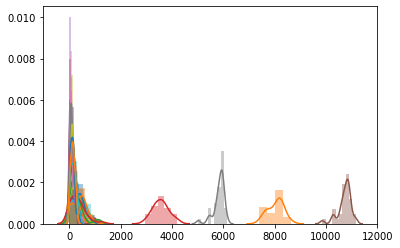

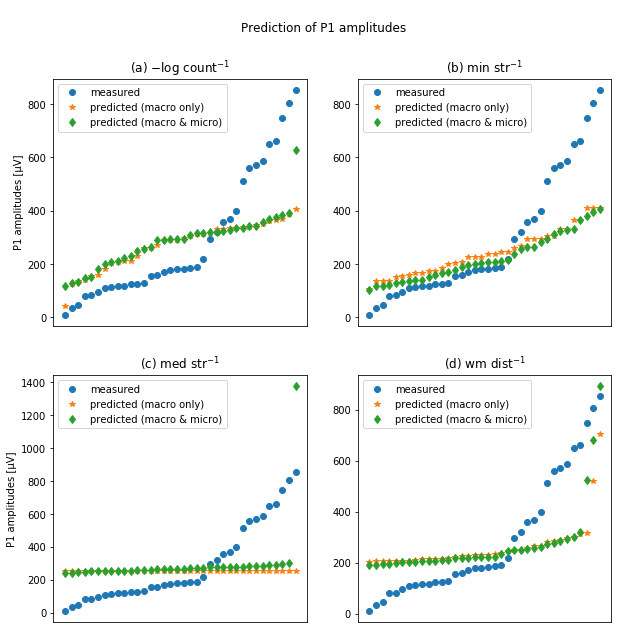

In [30]:
input_variables = [

  'streamlines_minus_log_count',   # 0
  'streamlines_min_length',        # 1
  'streamlines_median_length',     # 2
  'smoothwm_surface_distance',     # 3
  
  'fa_average',                    # 4
  'md_average',                    # 5
  'ad_average',                    # 6
  'rd_average',                    # 7
    
  'rtop_average',                  # 8
  'rtap_average',                  # 9
  'rtpp_average',                  # 10
  'msd_average',                   # 11
  'qiv_average',                   # 12
    
  'ng_average',                    # 13
  'ng_perp_average',               # 14
  'ng_par_average',                # 15
    
  'intraelectrode_distance'        # 16

]

eval_patient_id = 10

features_ids = [
    [ [0], [0, 5, 6, 14] ],
    [ [1], [1, 5, 6, 14] ],
    [ [2], [2, 5, 6, 14] ],
    [ [3], [3, 5, 6, 14] ],
]

dist_only_coefs = []
dist_only_intercepts = []

dist_and_micro_coefs = []
dist_and_micro_intercepts = []

for batch in get_batch_patient_ids(eval_patient_id): #, [1, 3, 4, 6, 7, 8, 10]):

    batch_dist_and_micro_coefs = []
    
    train_x, train_y = get_amplitude_features(batch[0], input_variables)
    test_x, test_y = get_amplitude_features(batch[1], input_variables)
    
    print("\nTrained on Patients: %s, Tested on Patients: %s" % (sorted(batch[0]), sorted(batch[1])))
    
    dist_only_accuracy = []
    dist_and_micro_accuracy = []
    
    for features_pair in features_ids:

        # distances only        
        result, _ = train_regression_model_of_amplitudes(train_x[:, features_pair[0]], train_y, test_x[:, features_pair[0]], test_y)
        result.append(str(features_pair[0]))
        dist_only_accuracy.append(result)

        # distances and microstructure
        result, coefs = train_regression_model_of_amplitudes(train_x[:, features_pair[1]], train_y, test_x[:, features_pair[1]], test_y)
        result.append(str(features_pair[1]))
        dist_and_micro_accuracy.append(result)
        batch_dist_and_micro_coefs.append(coefs)
        
    dist_only_accuracy_df = pd.DataFrame(dist_only_accuracy, columns = [
        'score', 'rmse', 'rmse_std', 'dummy_rmse', 'dummy_rmse_std', 'aic', 'bic', 'coef', 'intercept', 'features'
    ])
    print(dist_only_accuracy_df[['score', 'coef', 'rmse', 'rmse_std', 'features']].round({'score': 2, 'coef': 0, 'rmse' : 0, 'rmse_std': 0, 'bic': 1}))

    dist_and_micro_accuracy_df = pd.DataFrame(dist_and_micro_accuracy, columns = [
        'score', 'rmse', 'rmse_std', 'dummy_rmse', 'dummy_rmse_std', 'aic', 'bic', 'coef', 'intercept', 'features'
    ])
    print(dist_and_micro_accuracy_df[['score', 'coef', 'rmse', 'rmse_std', 'features']].round({'score': 2, 'coef': 0, 'rmse' : 0, 'rmse_std': 0, 'bic': 1}))
    
    
    dist_only_coefs.append(dist_only_accuracy_df['coef'].values)
    dist_only_intercepts.append(dist_only_accuracy_df['intercept'].values)
    
    dist_and_micro_coefs.append(batch_dist_and_micro_coefs)
    dist_and_micro_intercepts.append(dist_and_micro_accuracy_df['intercept'].values)
            

print("\nEvaluated on Patient: %d" % eval_patient_id)

mean_coefs = np.mean(np.array(dist_only_coefs), axis=0)
mean_intercepts = np.mean(np.array(dist_only_intercepts), axis=0)

eval_x, eval_y = get_amplitude_features([eval_patient_id], input_variables)

plt.figure(figsize=(10, 10))
plt.suptitle("\nPrediction of P1 amplitudes")

print("score\tcoef\trmse +/- std")
for i in range(len(mean_intercepts)):

    regr = linear_model.LinearRegression()
    regr.coef_ = mean_coefs[i]
    regr.intercept_ = mean_intercepts[i]
    pred_y = np.ravel(regr.predict(eval_x[:, features_ids[i][0]].reshape(-1, 1)))
    squared_error = (np.array(eval_y) ** 2 - np.array(pred_y) ** 2) ** 2
    print("%.2f\t%.2f\t%.0f +/- %.0f" % (
        regr.score(eval_x[:, features_ids[i][0]].reshape(-1, 1), eval_y), 
        mean_coefs[i],
        np.sqrt(np.mean(squared_error)), 
        np.sqrt(np.std(squared_error))
    ))

    plt.subplot(2, 2, i + 1)
    values = np.array([np.array(eval_y) ** 2, np.array(pred_y) ** 2])
    values.sort()
    plt.plot(values[0], linestyle="", marker="o", label="measured")
    plt.plot(values[1], linestyle="", marker="*", label="predicted (macro only)")
        
    
mean_coefs = np.mean(np.array(dist_and_micro_coefs), axis=0)
mean_intercepts = np.mean(np.array(dist_and_micro_intercepts), axis=0)

eval_x, eval_y = get_amplitude_features([eval_patient_id], input_variables)

print("score\tcoef\trmse +/- std")
for i in range(len(mean_intercepts)):

    regr = linear_model.LinearRegression()
    regr.coef_ = mean_coefs[i,:]
    regr.intercept_ = mean_intercepts[i]
    pred_y = np.ravel(regr.predict(eval_x[:, features_ids[i][1]]))
    squared_error = (np.array(eval_y) ** 2 - np.array(pred_y) ** 2) ** 2
    
    print("%.2f\t%.2f\t%.0f +/- %.0f" % (
        regr.score(eval_x[:, features_ids[i][1]], eval_y), 
        mean_coefs[i,0],
        np.sqrt(np.mean(squared_error)), 
        np.sqrt(np.std(squared_error))
    ))

    plt.subplot(2, 2, i + 1)
    values = np.array([np.array(eval_y) ** 2, np.array(pred_y) ** 2])
    values.sort()
    plt.plot(values[1], linestyle="", marker="d", label="predicted (macro & micro)")
    plt.xticks([])
    plt.legend()

plt.subplot(2, 2, 1)
plt.ylabel("P1 amplitudes [µV]")
plt.title("(a) $-$log count$^{-1}$")

plt.subplot(2, 2, 2)
plt.title("(b) min str$^{-1}$")

plt.subplot(2, 2, 3)
plt.ylabel("P1 amplitudes [µV]")
plt.title("(c) med str$^{-1}$")

plt.subplot(2, 2, 4)
plt.title("(d) wm dist$^{-1}$")

plt.savefig("amplitudes_prediction_accuracy.pdf", bbox_inches = 'tight')
plt.savefig("amplitudes_prediction_accuracy.eps", bbox_inches = 'tight')
        

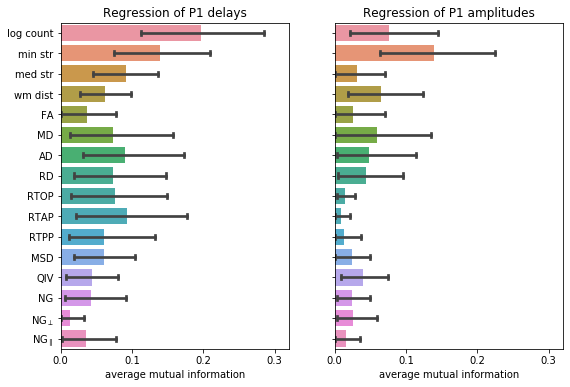

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

patient_ids = sorted(data_pd.keys())

feature_names = [
    'streamlines_log_count',    
    'streamlines_min_length',
    'streamlines_median_length',
    'smoothwm_surface_distance',
#     'streamlines_log_min_length',
#     'streamlines_sqrt_min_length',
#     'streamlines_count',
#     'pial_surface_distance',
#     'intraelectrode_distance',
    'fa_average', 'md_average', 'ad_average', 'rd_average',
    'rtop_average', 'rtap_average', 'rtpp_average', 'msd_average', 'qiv_average',
    'ng_average', 'ng_perp_average', 'ng_par_average'
]

feature_labels = {
    'streamlines_log_count': 'log count',    
    'streamlines_min_length': 'min str',
    'streamlines_median_length': 'med str',
    'smoothwm_surface_distance': 'wm dist',
    'fa_average': 'FA', 
    'md_average': 'MD', 
    'ad_average': 'AD', 
    'rd_average': 'RD',
    'rtop_average': 'RTOP',
    'rtap_average': 'RTAP', 
    'rtpp_average': 'RTPP', 
    'msd_average': 'MSD',
    'qiv_average': 'QIV',
    'ng_average': 'NG',
    'ng_perp_average': "NG$_\perp$",
    'ng_par_average': "NG$_\parallel$"
}

all_delay_scores = []
all_amplitude_scores = []

for patient_id in patient_ids: # [1, 4, 6, 7, 10]: 

    # delays
    x, y = get_delay_features([patient_id], feature_names)
    selection = SelectKBest(score_func=mutual_info_regression, k=1)
    fit = selection.fit(x, y)

    all_delay_scores.append(fit.scores_)
    
    # amplitudes
    x, y = get_amplitude_features([patient_id], feature_names)
    selection = SelectKBest(score_func=mutual_info_regression, k=1)
    fit = selection.fit(x, y)
    
    all_amplitude_scores.append(fit.scores_)
    
    
# Summarize scores
plt.figure(figsize=(9, 6))


plt.subplot(1, 2, 1)
plt.title("Regression of P1 delays")

sns.barplot(data=np.array(all_delay_scores), capsize=.2, orient="h")

y_labels = []
for feature_name in feature_names:
    y_labels.append(feature_labels[feature_name])

plt.xlim([0, 0.32])
plt.xticks(np.arange(0, 0.31, 0.1))
plt.xlabel('average mutual information')
plt.yticks(range(len(feature_names)), y_labels)


plt.subplot(1, 2, 2)
plt.title("Regression of P1 amplitudes")

sns.barplot(data=np.array(all_amplitude_scores), capsize=.2, orient="h")

y_labels = []
for feature_name in feature_names:
    y_labels.append(feature_labels[feature_name])

plt.xlim([0, 0.32])
plt.xticks(np.arange(0, 0.31, 0.1))
plt.xlabel('average mutual information')
plt.yticks(range(len(feature_names)), [])

plt.savefig("mutual_info_regression.pdf", bbox_inches = 'tight')
plt.savefig("mutual_info_regression.eps", bbox_inches = 'tight')

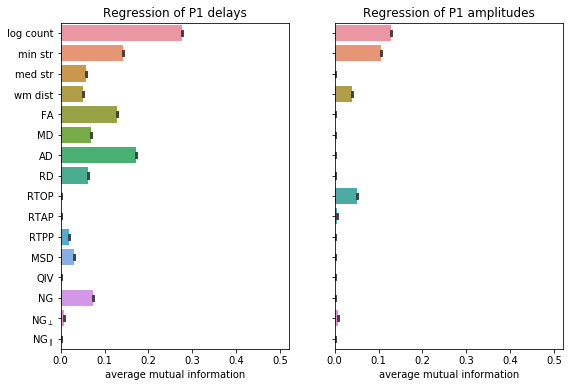

In [32]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

patient_ids = sorted(data_pd.keys())

feature_names = [
    'streamlines_log_count',    
    'streamlines_min_length',
    'streamlines_median_length',
    'smoothwm_surface_distance',
#     'streamlines_log_min_length',
#     'streamlines_sqrt_min_length',
#     'streamlines_count',
#     'pial_surface_distance',
#     'intraelectrode_distance',
    'fa_average', 'md_average', 'ad_average', 'rd_average',
    'rtop_average', 'rtap_average', 'rtpp_average', 'msd_average', 'qiv_average',
    'ng_average', 'ng_perp_average', 'ng_par_average'
]

feature_labels = {
    'streamlines_log_count': 'log count',    
    'streamlines_min_length': 'min str',
    'streamlines_median_length': 'med str',
    'smoothwm_surface_distance': 'wm dist',
    'fa_average': 'FA', 
    'md_average': 'MD', 
    'ad_average': 'AD', 
    'rd_average': 'RD',
    'rtop_average': 'RTOP',
    'rtap_average': 'RTAP', 
    'rtpp_average': 'RTPP', 
    'msd_average': 'MSD',
    'qiv_average': 'QIV',
    'ng_average': 'NG',
    'ng_perp_average': "NG$_\perp$",
    'ng_par_average': "NG$_\parallel$"
}

all_delay_scores = []
all_amplitude_scores = []

for patient_id in [12]: # patient_ids: # [1, 4, 6, 7, 10]: 

    # delays
    x, y = get_delay_features([patient_id], feature_names)
    selection = SelectKBest(score_func=mutual_info_regression, k=1)
    fit = selection.fit(x, y)

    all_delay_scores.append(fit.scores_)
    
    # amplitudes
    x, y = get_amplitude_features([patient_id], feature_names)
    selection = SelectKBest(score_func=mutual_info_regression, k=1)
    fit = selection.fit(x, y)
    
    all_amplitude_scores.append(fit.scores_)
    
    
# Summarize scores
plt.figure(figsize=(9, 6))


plt.subplot(1, 2, 1)
plt.title("Regression of P1 delays")

sns.barplot(data=np.array([all_delay_scores[0], all_delay_scores[0]]), capsize=.2, orient="h")

y_labels = []
for feature_name in feature_names:
    y_labels.append(feature_labels[feature_name])

plt.xlim([0, 0.52])
plt.xticks(np.arange(0, 0.51, 0.1))
plt.xlabel('average mutual information')
plt.yticks(range(len(feature_names)), y_labels)


plt.subplot(1, 2, 2)
plt.title("Regression of P1 amplitudes")

sns.barplot(data=np.array([all_amplitude_scores[0], all_amplitude_scores[0]]), capsize=.2, orient="h")

y_labels = []
for feature_name in feature_names:
    y_labels.append(feature_labels[feature_name])

plt.xlim([0, 0.52])
plt.xticks(np.arange(0, 0.51, 0.1))
plt.xlabel('average mutual information')
plt.yticks(range(len(feature_names)), [])

plt.savefig("mutual_info_regression_10.pdf", bbox_inches = 'tight')
plt.savefig("mutual_info_regression_10.eps", bbox_inches = 'tight')

# Prediction of streamline log counts

In [33]:
def get_log_count_features(patient_ids, feature_names):
    
    x = None
    y = []
    
    for patient_id in patient_ids:

        features = {}
        
        # P1 delays
        effective_connectivity_matrix = get_evoked_potential_delay_matrix(data_pd[patient_id])
        features['delay'] = effective_connectivity_matrix[masks[patient_id]]

        # P1 amplitude
        effective_connectivity_matrix = get_evoked_potential_amplitude_matrix(data_pd[patient_id])
        features['amplitude'] = effective_connectivity_matrix[masks[patient_id]]
                
        feature_matrix = None
        for feature_name in feature_names:
            
            if feature_matrix is None:
                feature_matrix = features[feature_name]
            else:
                feature_matrix = np.c_[feature_matrix, features[feature_name]]
            
        if x is None:
            x = feature_matrix
        else:
            x = np.r_[x, feature_matrix]

        structural_connectivity_matrix = get_streamlines_log_count_matrix(data_pd[patient_id])
        y.extend(structural_connectivity_matrix[masks[patient_id]])

    return x, y
    

(0, 0.4)

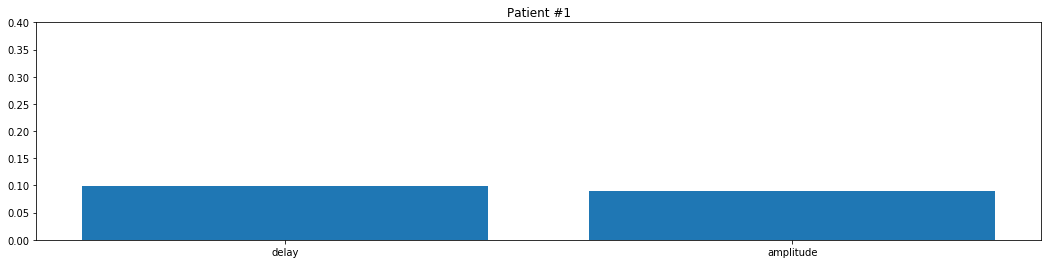

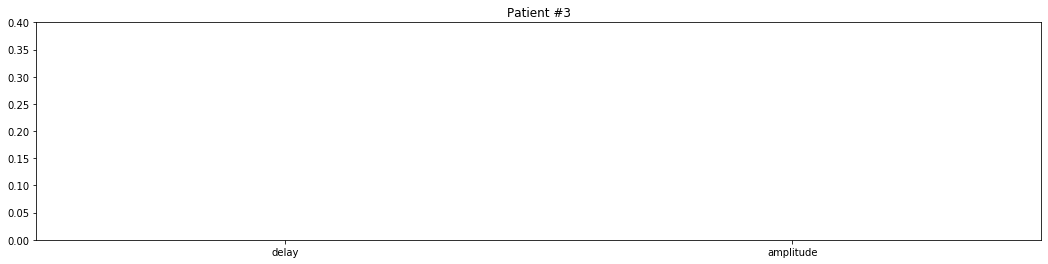

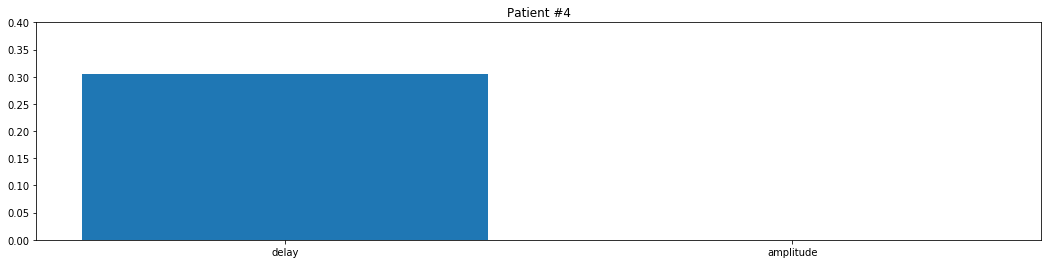

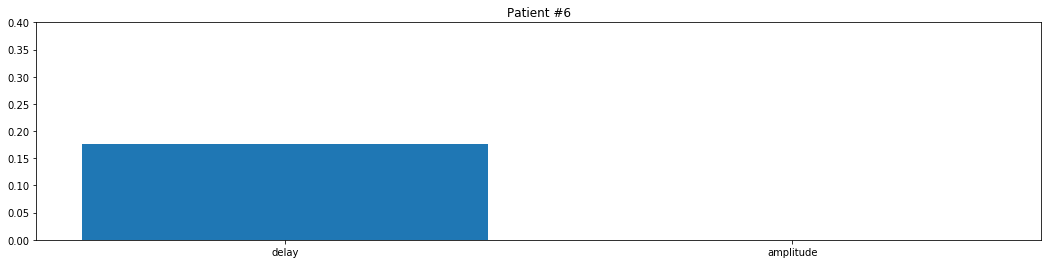

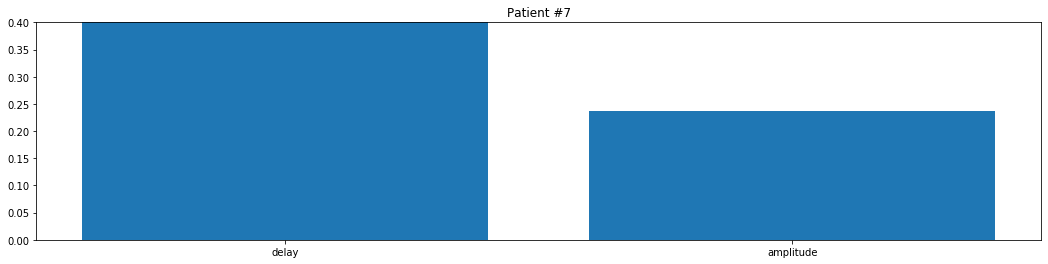

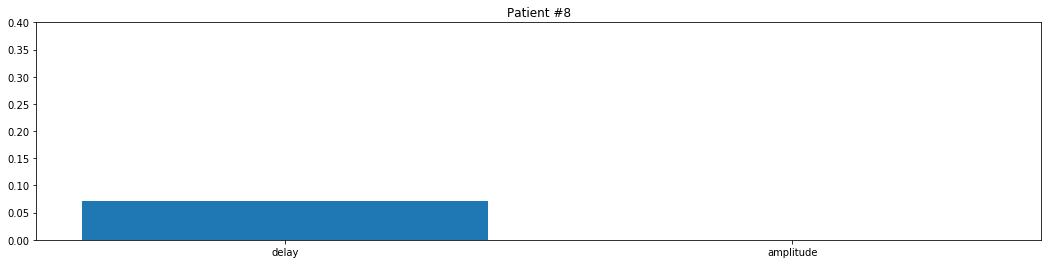

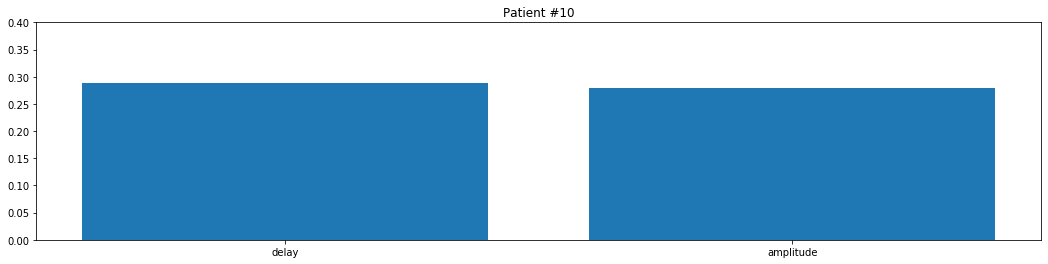

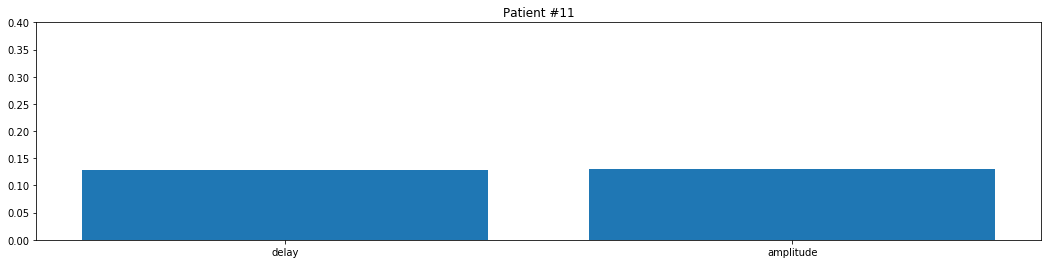

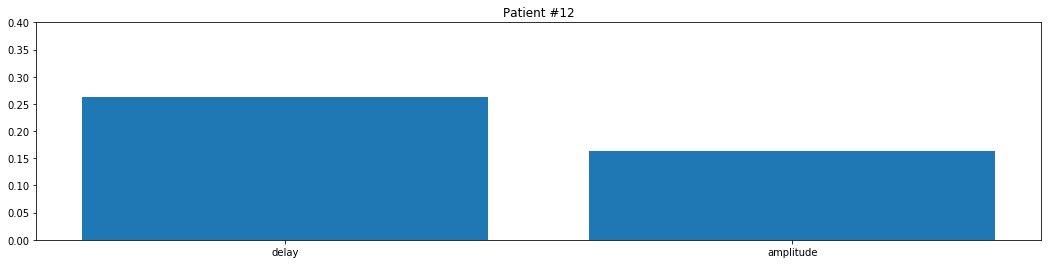

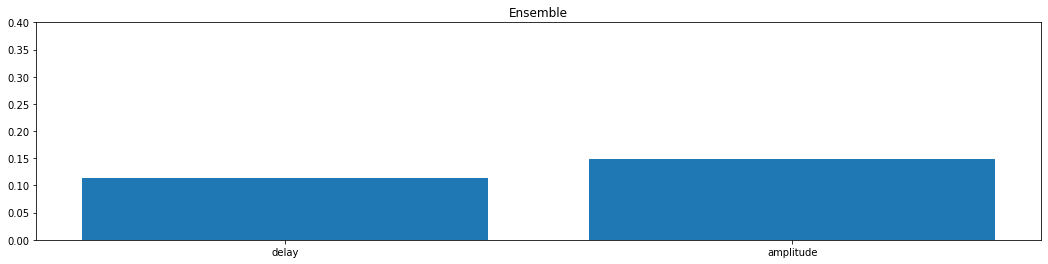

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

patient_ids = sorted(data_pd.keys())

feature_names = [
    'delay',
    'amplitude'
]

for patient_id in patient_ids:
    
    x, y = get_log_count_features([patient_id], feature_names)

    # Feature extraction
    selection = SelectKBest(score_func=mutual_info_regression, k=1)
    fit = selection.fit(x, y)

    # Summarize scores
    plt.figure(figsize=(18, 4))
    plt.title("Patient #%d" % patient_id)
    plt.bar(range(len(fit.scores_)), fit.scores_, tick_label=feature_names)
    plt.ylim([0, 0.4])    

x, y = get_log_count_features(patient_ids, feature_names)

# Feature extraction
selection = SelectKBest(score_func=mutual_info_regression, k=1)
fit = selection.fit(x, y)

# Summarize scores
plt.figure(figsize=(18, 4))
plt.title("Ensemble")
plt.bar(range(len(fit.scores_)), fit.scores_, tick_label=feature_names)
plt.ylim([0, 0.4])


In [35]:
input_variables = [
    'delay',
    'amplitude'
]

for batch in batch_patient_ids:

    train_x, train_y = get_log_count_features(batch[0], input_variables)
    test_x, test_y = get_log_count_features(batch[1], input_variables)
    
    plt.figure()
    print("\nTrained on Patients: %s, Tested on Patients: %s" % (sorted(batch[0]), sorted(batch[1])))
    
    features_num = train_x.shape[1]    
    accuracy = []
    for subset_size in range(1, features_num + 1):
        for features_id in itertools.combinations(range(features_num), subset_size):
    
            result = train_regression_model(train_x[:, features_id], train_y, test_x[:, features_id], test_y)
            result.append(str(features_id))
            accuracy.append(result)
            
    accuracy_df = pd.DataFrame(accuracy, columns = ['score', 'rmse', 'rmse_std', 'dummy_rmse', 'dummy_rmse_std', 'features'])
    print(accuracy_df.sort_values(by=['score'], ascending=False)[['score', 'rmse', 'rmse_std', 'dummy_rmse', 'dummy_rmse_std', 'features']].head(10))
    plt.legend()



Trained on Patients: [6, 7, 10], Tested on Patients: [4]


TypeError: train_regression_model() missing 3 required positional arguments: 'x_label', 'y_label', and 'train_patient_ids'

<Figure size 432x288 with 0 Axes>

# Streamlines

In [ ]:
def shortest_streamlines(patient_id, data_pd, shortest_streamlines_fraction = .1):

    streamlines_path = os.path.join(
        data_dir, "patient%02d/bids/sub-patient%02d/ses-presurgical/connectivity/streamlines/" % (
        patient_id, patient_id
    ))
    
    stimulation_sites = sorted(data_pd.iloc[:, 0].unique())
    stimulation_sites_num = len(stimulation_sites)

    electrodes = sorted(data_pd.iloc[:, 1].unique())
    electrodes_num = len(electrodes)

    functional_connectivity_matrix = get_amplitude_based_connectivity_matrix(data_pd)

    structural_shortest_streamlines = []
    functional_shortest_streamlines = []
    
    for stimulation_site in stimulation_sites:
        for electrode in electrodes:
            
            print("%s_%s_diam10_in00.trk" % (stimulation_site.strip(), electrode.strip()))
            
            trk_file = nib.streamlines.load(os.path.join(
                streamlines_path, 
                "%s_%s_diam10_in00.trk" % (stimulation_site.strip(), electrode.strip())
            ))
            
            streamlines_lengths = list(dipy.tracking.utils.length(trk_file.streamlines))
            streamlines = list(trk_file.streamlines)
            
            row_id = stimulation_sites.index(stimulation_site)
            col_id = electrodes.index(electrode)

            shortest_streamlines_num = int(np.round(shortest_streamlines_fraction * len(streamlines)))
            for i in range(shortest_streamlines_num):

                if len(streamlines_lengths) == 0:
                    break
                
                shortest_streamline_id = np.argmin(streamlines_lengths)
                shortest_streamline = streamlines.pop(shortest_streamline_id)
                streamlines_lengths.pop(shortest_streamline_id)
                
                structural_shortest_streamlines.append(shortest_streamline)

                if functional_connectivity_matrix[row_id, col_id] > 0:
                    functional_shortest_streamlines.append(shortest_streamline)
            
    nib.streamlines.save(
        nib.streamlines.Tractogram(structural_shortest_streamlines, affine_to_rasmm=trk_file.affine), 
        "structural_shortest_streamlines_patient%02d_num%d.trk" % (patient_id, shortest_streamlines_num)
    )

    nib.streamlines.save(
        nib.streamlines.Tractogram(functional_shortest_streamlines, affine_to_rasmm=trk_file.affine), 
        "functional_shortest_streamlines_patient%02d_num%d.trk" % (patient_id, shortest_streamlines_num)
    )


In [ ]:
# patient_id = 1
# shortest_streamlines(patient_id, data_pd[patient_id])